In [132]:

#-----------------------------------------------------------------------------------------------------
# Author:  Tom Bresee
# Kaggle:  Tabular Data May 2021 v5.21
#-----------------------------------------------------------------------------------------------------
#
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
#
#   output of above code would be:
#    /kaggle/input/tabular-playground-series-may-2021/sample_submission.csv
#    /kaggle/input/tabular-playground-series-may-2021/train.csv
#    /kaggle/input/tabular-playground-series-may-2021/test.csv
# 
#-----------------------------------------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")
#-----------------------------------------------------------------------------------------------------
from IPython.display import HTML
#-----------------------------------------------------------------------------------------------------
# --- common standard libraries ---
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
import seaborn as sns
import graphviz
import altair as alt
import plotly.express as px
#-----------------------------------------------------------------------------------------------------
# --- scientific stuff ---
import scipy.sparse
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report
import scipy.sparse as sparse
#-----------------------------------------------------------------------------------------------------
# --- main ML algorithm ---
import xgboost as xgb
# from xgboost import XGBClassifier 
# from xgboost import plot_importance, plot_tree
# i import entirely library, I actually prefer to 
# use xgb.<something>, in case someone thinks for
# instance plot_tree is something from sklearn
# or matplotlib or altair or whatever...
import lightgbm as lgb
#-----------------------------------------------------------------------------------------------------
from IPython.core.display import display, HTML
import pickle
import json 
#-----------------------------------------------------------------------------------------------------
# --- i may use gridsearch or do more complicated optuna ---
import lightgbm as lgb
import optuna.integration.lightgbm as lgb
#-----------------------------------------------------------------------------------------------------
# --- read in files and process --- 
# a. I will specify the files to read in 
#    I also can say i don't need that 'id' column, its superficial, 
#    i.e. it brings no real 'information' to the table...
sample_sub = pd.read_csv("/kaggle/input/tabular-playground-series-may-2021/sample_submission.csv")
train_df   = pd.read_csv("/kaggle/input/tabular-playground-series-may-2021/train.csv")
#    later i will find i need to do this
# train_df['target'] = train_df['target'].map({'Class_1':0, 'Class_2':1, 'Class_3':2, 'Class_4':3})
#    I think this looks better: 
train_df.rename(columns = lambda x: x.replace('_', ' '), inplace=True) 
test_df    = pd.read_csv("/kaggle/input/tabular-playground-series-may-2021/test.csv")
#-----------------------------------------------------------------------------------------------------
# b.  clean and make ready input
# X_train = train_df.copy()
# remove the id and target col obviously
# X_train.drop(columns=["id", "target"], inplace=True)
# y_train = train_df.copy()
# y_train = y_train['target']
#     consolidate and remove the id and target at the same time
X_train, X_val, y_train, y_val = train_test_split(
    train_df.drop(columns=["id","target"]), 
    train_df.target, 
    test_size=0.1,
    random_state = 42,
    stratify=train_df.target)

X_test=test_df.drop(columns="id")
#-----------------------------------------------------------------------------------------------------
# appendix. random notes / stuff 
# # type(bst)  # xgboost.sklearn.XGBClassifier < -  
# fix: 
# xgb.plot_tree(bst, num_trees=2)
# fig = matplotlib.pyplot.gcf()
# # fig.set_size_inches(150, 100)
# fig.set_size_inches(180.5, 16.5)
# plt.show()
# # fig.savefig('tree.svg')
# --- creating example table for clarity --- 
# print = pd.DataFrame({'Data': ['100,000',  '50', 'int64', '0','4']})
# print.index=['Total Rows of Data', 
#              'Number of Features', 
#              'Features Dtype', 
#              'Num Missing Values',
#              'Number of target classes']
# print.to_html()
#
# --- utility for download hi-rez images ---
def download_my_file(my_file):
    import os 
    os.chdir(r'/kaggle/working')
    from IPython.display import FileLink 
    FileLink(my_file)
#
# --- replacing ---
#    y.replace({1:0, 2:1, 3:2, 4:3, 5:4}, inplace = True)
#-----------------------------------------------------------------------------------------------------
# --- download latest xgboost ---
# !pip install xgboost --upgrade 
# print("xgb version: {}". format(xgb.__version__))
#-----------------------------------------------------------------------------------------------------
# interesting links:
# https://www.avato-consulting.com/?p=28903&lang=en
# python json_parser_python_function.py --model try_to_parse_this.json
# https://www.kaggle.com/c/higgs-boson/discussion/10286
# https://www.datacamp.com/community/tutorials/xgboost-in-python
# https://github.com/dmlc/xgboost/blob/master/demo/json-model/json_parser.py
# https://dzone.com/articles/inspecting-decision-trees-in-h2o
# https://xgboost.readthedocs.io/en/latest/parameter.html
# https://stackoverflow.com/questions/33520460/how-is-xgboost-cover-calculated
# print("XGBoost Library Version:  --->  {}". format(xgb.__version__))
# 

In [138]:
%%HTML

<style type="text/css">
       

div.h2 {
 color: white;
 background-image: linear-gradient(120deg, #155799, #159957);
 text-align: left;             
 padding:9px;
 padding-right: 100px; 
 font-size: 20px;  
 max-width: 1500px;  
 margin: auto; 
 margin-top: 40px;}                                   
             
                                                                     
div.h3 {
    color: #159957; 
    font-size: 18px; 
    margin-top: 20px; 
    margin-bottom:4px;
       }
   
                                      
div.h4 {
    color: #159957;
    font-size: 16px; 
    margin-top: 20px; 
    margin-bottom: 8px;
}
     
body {font-size: 11px;}   
                                       
span.note {
    font-size: 5; 
    color: gray; 
    font-style: italic;
}
                                       
hr {display: block; 
    color: gray
    height: 1px; 
    border: 0; 
    border-top: 1px solid;}
                                     
hr.light {display: block; 
          color: lightgray
          height: 1px; 
          border: 0; 
          border-top: 1px solid;}   
                                   
table.dataframe th 
{
    border: 1px darkgray solid;
    color: black;
      <table align="left">
    ...
  </table>
    background-color: white;
}
    
                                      
table.dataframe td 
{
    border: 1px darkgray solid;
    color: black;
    background-color: white;
    font-size: 10px;
    text-align: center;
} 
                                            
table.rules th 
{
    border: 1px darkgray solid;
    color: black;
    background-color: white;
    font-size: 10px;
    align: left;
}
                                            
table.rules td 
{
    border: 1px darkgray solid;
    color: black;
    background-color: white;
    font-size: 13px;
    text-align: center;
} 
                                                                           
table.rules tr.best
{
    color: green;
}    
    
                                      
.output { 
    align-items: left; 
}
        
                                      
.output_png {
    display: table-cell;
    text-align: left;
    margin:auto;
}                                          
                                                                                                                               
</style>  

The above standard starter code can also be found [here](https://raw.githubusercontent.com/tombresee/XGBOOST/main/ENTER/base_starter_section_of_code.txt) as well for viewing ease, I just think its a touch easier to see the actual txt on github. Also, eventually smart move is to click 'Accelerator' and set to enable GPU. For now leaving standard CPU. 

<div class="h2"><i><center>Kaggle Tabular Data Series</center></i></div>
<div class="h3"><i><center>May 2021</center></i></div>

<div class="h3"><i>1. &ensp; Introduction</i></div> 

* **Author:** &nbsp; Tom Bresee
* **Contact 1:** &nbsp; tbresee@umich.edu
* **Contact 2:** &nbsp; tom.bresee@t-mobile.com
* **Location:** &nbsp; Frisco, Texas
* **LinkedIn:** &nbsp; [Tom Bresee](https://www.linkedin.com/in/tombresee/)
* **Notebook Template Format:** &nbsp; Streamlined 

In [88]:
!pip install xgboost --upgrade
!pip install optuna --upgrade

<div class="h3"><i>2.&ensp; Overall Approach</i></div>  

* I'm going to take a bit of a different approach here.  I am going to try to streamline the notebook with external links here and there, as well as minimize code and get straight to the problem and attempt to solve it. I also will attempt to create the notebook in a way where it is more optimal for smartphone viewing. 

* **Drivers License Concept** - One could argue that today more and more data scientists are using machine learning algorithms that they may not understand fully, but do know the basics of how to get answers from, without also knowing how to measure how accurate/successful those algorithms actually are. Some of these machine learning algorithms are immensely powerful, and yet are wielded in unhealthy or unnatural ways. One could argue that one shouldn't necessarily use a specific machine learning algorithm without **truly understanding it**.  Just as young adults today are not allowed to drive a vehicle until after they pass a written and practical test, one could argue that one shouldn't be allowed to use certain powerful machine learning algorithms until one has obtained the data science equivalent of a `Drivers License`, demonstrating beginner level proficiency, on the road to intermediate-level understanding, and then eventually advanced-level understanding. I attempt to demonstrate the basics of the XGBoost algorithm. 

<div class="h4"><i>Read</i></div>  


* Read xgboost user guide downloaded from [here](https://xgboost.readthedocs.io/_/downloads/en/release_1.4.0/pdf/), the release 1.4.2 version and analyze:
  * xgboost allows training with multiple GPUs only on linux platforms (not windows, which means the million years it took me to get all my multiple gpus on my windows platform to function correctly won't help me).  no big deal.  why ?  because xgboost is very very very fast out of the box. nice.  also, make sure if you do run on windows that you download a up-to-date version of the cuda toolkit.  done. 
  * user docs refer to the classifier or models as 'bst' (they don't use names like `clf` like scikit-learn does.  ok fine.  we will call our classifer model `bst` for clarity)
  * wow julia support, nice. something i worked with a while back, kinda nice. the mighty scala as well.
  * the term 'boosting' itself is not very descriptive and relatable (boost usually has the connotation of helping or increasing, which um doesn't help me undestand),  i'll just start calling it boosting sequential ensemble instead. 
  * interesting:  couldn't actually get this to command to take:  bst.save_config()
 


<div class="h3"><i>3. &ensp; Training Data Summary</i></div>

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>Data</th>    </tr>  </thead>  <tbody>    <tr>      <th>Total Rows of Data</th>      <td>100,000</td>    </tr>    <tr>      <th>Number of Features</th>      <td>50</td>    </tr>    <tr>      <th>Features Dtype</th>      <td>int64</td>    </tr>    <tr>      <th>Num Missing Values</th>      <td>0</td>    </tr>    <tr>      <th>Number of target classes</th>      <td>4</td>    </tr>  </tbody></table>


* Features are labelled `feature_0` thru `feature_49` (which makes it easy to view), and are all int64 dtypes
* This is important:  None of the features are actually encoded as text/strings/objects, they are **all** base integers (symbolizing feature categories is assumed).  Effectively, the dataset has been converted to numeric for us for easy of understanding (as if original dataset had true categories, and then was label encoded into intergers symbolizing categories)
* Fairly large dataset of 100,000 rows (or what I would call `observations` to be technical, resulting in 5M individual cells of data
* No missing values as verified with _.isnull().sum()_ command
* Approach:  Dive into the EDA, come up with a reasonable ML algorithm and method
* Remember, later we will see that we can delete the 'id' column, since its not actually pertinent nor a feature, and thus our dataframes are all going to either have the feature_0 - feature_49, or just have the target class, but for now its safe to delete the 'id' col as it brings nothing substantial in any form to the model
* Note:  Test data follows similar trend as the training data, but there are only 50k observations (rows) of data


**XGBoost:** Default library version initially was 1.4.0, but i forced an upgrade to 1.4.2 (very latest version as of May 2021) !  

<div class="h3"><i>4. &ensp; Balance Check</i></div> 

In [89]:
# are we balanced or imbalanced ?  you decide
#
# I actually like to use Altair, lots of advantages I believe compared
# to some other visualization approaches

source1 = pd.DataFrame({
    'a': list(train_df['target'].value_counts(sort=True).values), 
    'b': list(train_df['target'].value_counts(sort=True).index.values)})

source2 = pd.DataFrame({
    'a': list(train_df['target'].value_counts(sort=True, normalize=True).values), 
    'b': list(train_df['target'].value_counts(sort=True, normalize=True).index.values)})

chart1 = alt.Chart(source1).mark_bar(color='red', opacity=.55).encode(
    x=alt.X('a', title='class instances counts'),
    y=alt.Y('b', title=None)).properties(width=410, height=120)

chart2 = alt.Chart(source2).mark_bar(color='blue', opacity=.55).encode(
    x=alt.X('a', title='class instances (in % format)', axis=alt.Axis(format='%')),
    y=alt.Y('b', title=None)).properties(width=410, height=120)

# i like how with altair you can render in svg form, looks
# pretty sharp and clear... 
(chart1  &  chart2).properties(title='Target Class Distribution - Training Data').display(renderer='svg')


alt.VConcatChart(...)

Numeric Summary of Above Charts:

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>Instance Counts</th>      <th>% of Total Obs</th>    </tr>  </thead>  <tbody>    <tr>      <th>Class 2</th>      <td>57,497</td>      <td>57.50</td>    </tr>    <tr>      <th>Class 3</th>      <td>21,420</td>      <td>21.42</td>    </tr>    <tr>      <th>Class 4</th>      <td>12,593</td>      <td>12.60</td>    </tr>    <tr>      <th>Class 1</th>      <td>8,490</td>      <td>8.49</td>    </tr>  </tbody></table>

* Closep of above target class distribution (in red and blue) image can be found [here](https://raw.githubusercontent.com/tombresee/XGBOOST/main/ENTER/counts.svg) 
* So you know how the iris dataset has three classes/targets (0 = setosa, 1 = versicolor, 2 = virginica)? This tabular dataset has 4 classes/targets, initially labelled (as string/object) Class_1, Class_2, Class_3, and Class_4.  I will relabel these obviously as numeric, and have chosen to re-assign them the integer values:  1, 2, 3, and 4.  I have **not** chosen to label them as 0,1,2, and 3, because I don't particularly like 0-based approaches, its harder to really visualize whats going on... 
* Just like the iris dataset has 4 features (sepal length, sepal width, petal length, petal width), this tabular dataset we are given has 50 features, **none** of which you can conclude too much about since they are given generic names of `feature_0` to `feature_49` 
* The real question is how severe is the imbalance below ? We will dive into this, its possible that using the default value scale_pos_weight of 1 is adequate ? 
* What we observe is a <u>*somewhat*</u> imbalanced classes, with Class 2 dominating with 57.50% of the total observation counts, almost 7x the Class 1 count and over 4x the Class 4 count...

<div class="h3"><i>5. &ensp; Training Data Feature Value Distribution</i></div> 

* I am going to re-use some medal awarded visualization [notebook code](https://www.kaggle.com/tombresee/nfl-eval) I did from the past [2021 NFL Big Data Bowl](https://www.kaggle.com/c/nfl-big-data-bowl-2021), but if you want to just see the below code, click [here](https://raw.githubusercontent.com/tombresee/XGBOOST/main/ENTER/initial_histogram.txt)
* When you have a large number of features, plotting things horizontally doesn't work very well, I choose to plot this vertically and I dont facet it into rows and columns, i like to be able to quickly compare every feature to the others...

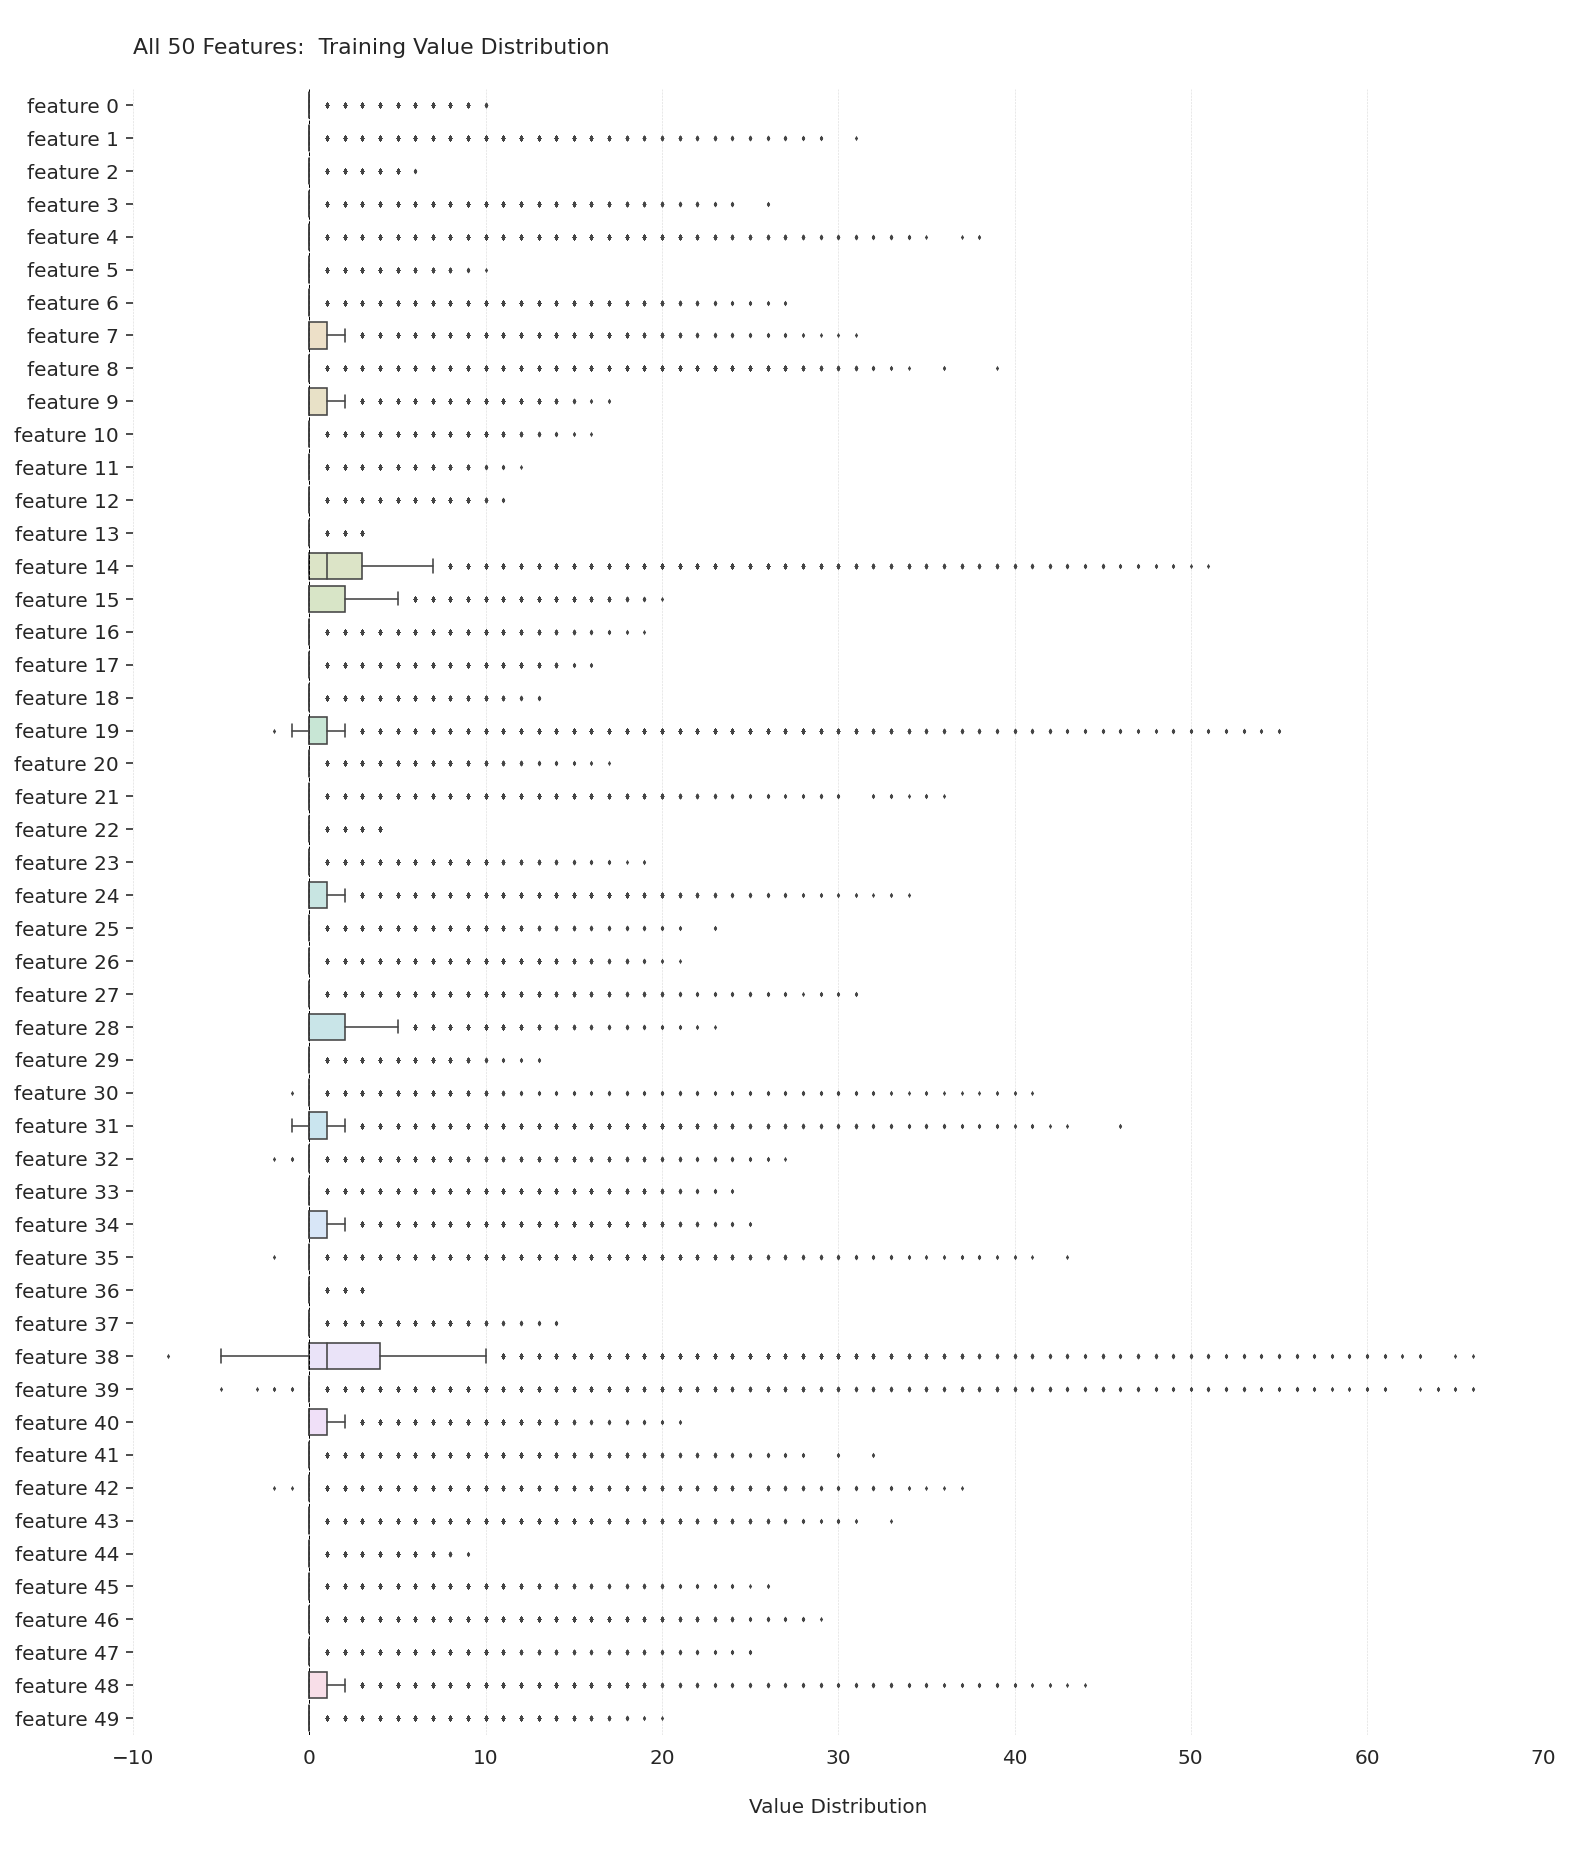

In [90]:
# this line is very important
train_df['target'] = train_df['target'].map({'Class_1':0, 'Class_2':1, 'Class_3':2, 'Class_4':3})
temp = train_df.copy()
temp.drop(['id','target'], inplace=True, axis=1)
import pandas as pd
pd.set_option('display.max_rows', None)
sns.set_style("ticks", {'grid.linestyle': '--'})

flierprops = dict(markerfacecolor='0.2', 
                  markersize=10,
                  linestyle='none')

fig, ax = plt.subplots(figsize=(11, 13))

ax.set_ylim(-7, 22)

ax.set_title('\nAll 50 Features:  Training Value Distribution\n', fontsize=11, loc='left')

# sns.boxplot(y='DefensePersonnel',
#             x='Yards',
#             data=dff,
#             ax=ax,
#             showfliers=False , 
#             #color='blue'
#             )

# sns.boxplot(y=dff['personnelD'].sort_values(ascending=False),
#             x=dff['offensePlayResult'],
#             ax=ax,
#             showfliers=False ,
#             linewidth=.8
#             #color='blue'
#             )

sns.boxplot(data=temp, 
            orient="h",
            ax=ax,
            showfliers=True,
            fliersize=.5,
            linewidth=.8
            #color='blue'
            )

# ax.yaxis.grid(False)   # Show the horizontal gridlines
# ax.xaxis.grid(True)  # Hide x-axis gridlines 
ax.xaxis.set_major_locator(plt.MultipleLocator(10))

# Add transparency to colors
for patch in ax.artists:
  r, g, b, a = patch.get_facecolor()
  patch.set_facecolor((r, g, b, .3))
    
# ax.set(xlabel=''common xlabel', ylabel='common ylabel', title='some title')
ax.set(xlabel="\nValue Distribution\n")

sns.despine(top=True, right=True, left=True, bottom=True)

ax.xaxis.set_ticks_position('none') 

ax.set_ylabel('')

#-----more control-----#
ax.grid(linestyle='--', 
        linewidth='0.3', 
        color='lightgray', 
        alpha=0.8,
        axis='x'
       )

plt.xlim(-10, 70)
plt.axvline(0, 0,1, linewidth=.5, color="black", linestyle="--")
plt.tight_layout()

# import os
# os.chdir(r'/kaggle/working')
# from IPython.display import FileLink 
# FileLink(r'closeup_histogram.svg')

plt.show();

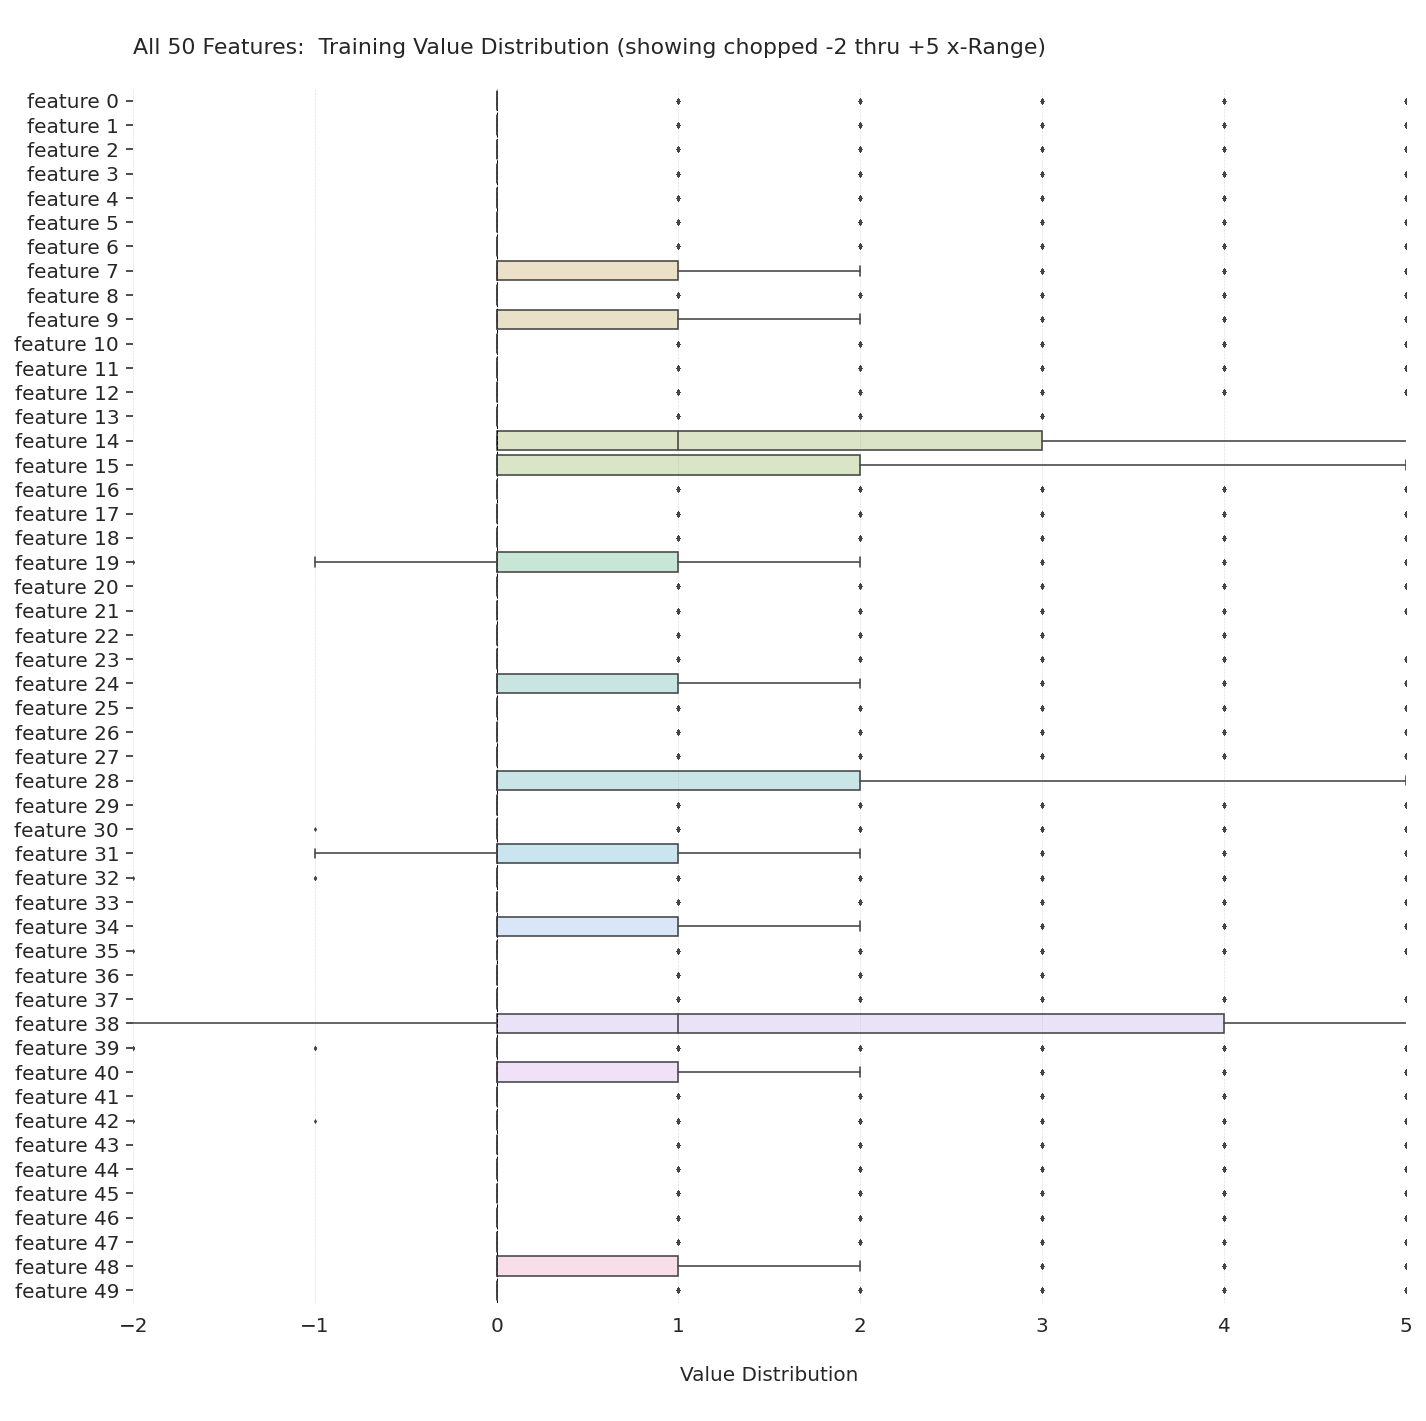

In [91]:
# this line is very important
train_df['target'] = train_df['target'].map({'Class_1':1, 'Class_2':2, 'Class_3':3, 'Class_4':4})
temp = train_df.copy()
temp.drop(['id','target'], inplace=True, axis=1)
import pandas as pd
pd.set_option('display.max_rows', None)
sns.set_style("ticks", {'grid.linestyle': '--'})

flierprops = dict(markerfacecolor='0.2', 
                  markersize=10,
                  linestyle='none')

fig, ax = plt.subplots(figsize=(10,10))

ax.set_xlim(-1, 1)

ax.set_title('\nAll 50 Features:  Training Value Distribution (showing chopped -2 thru +5 x-Range)\n', fontsize=11, loc='left')

# sns.boxplot(y='DefensePersonnel',
#             x='Yards',
#             data=dff,
#             ax=ax,
#             showfliers=False , 
#             #color='blue'
#             )

# sns.boxplot(y=dff['personnelD'].sort_values(ascending=False),
#             x=dff['offensePlayResult'],
#             ax=ax,
#             showfliers=False ,
#             linewidth=.8
#             #color='blue'
#             )

sns.boxplot(data=temp, 
            orient="h",
            ax=ax,
            showfliers=True,
            fliersize=.5,
            linewidth=.8
            #color='blue'
            )

# ax.yaxis.grid(False)   # Show the horizontal gridlines
# ax.xaxis.grid(True)  # Hide x-axis gridlines 
ax.xaxis.set_major_locator(plt.MultipleLocator(1))

# Add transparency to colors
for patch in ax.artists:
  r, g, b, a = patch.get_facecolor()
  patch.set_facecolor((r, g, b, .3))
    
# ax.set(xlabel=''common xlabel', ylabel='common ylabel', title='some title')
ax.set(xlabel="\nValue Distribution\n")

sns.despine(top=True, right=True, left=True, bottom=True)

ax.xaxis.set_ticks_position('none') 

ax.set_ylabel('')

#-----more control-----#
ax.grid(linestyle='--', 
        linewidth='0.3', 
        color='lightgray', 
        alpha=0.8,
        axis='x'
       )

plt.xlim(-2, 5)
plt.axvline(0, 0,1, linewidth=.5, color="black", linestyle="--")
plt.tight_layout()
plt.show();

* Somewhat unusual feature values distribution, many of the features have values centered closely around 0...
* Let's zoom in **ONLY** on the features that appear to be mainly non-zero:

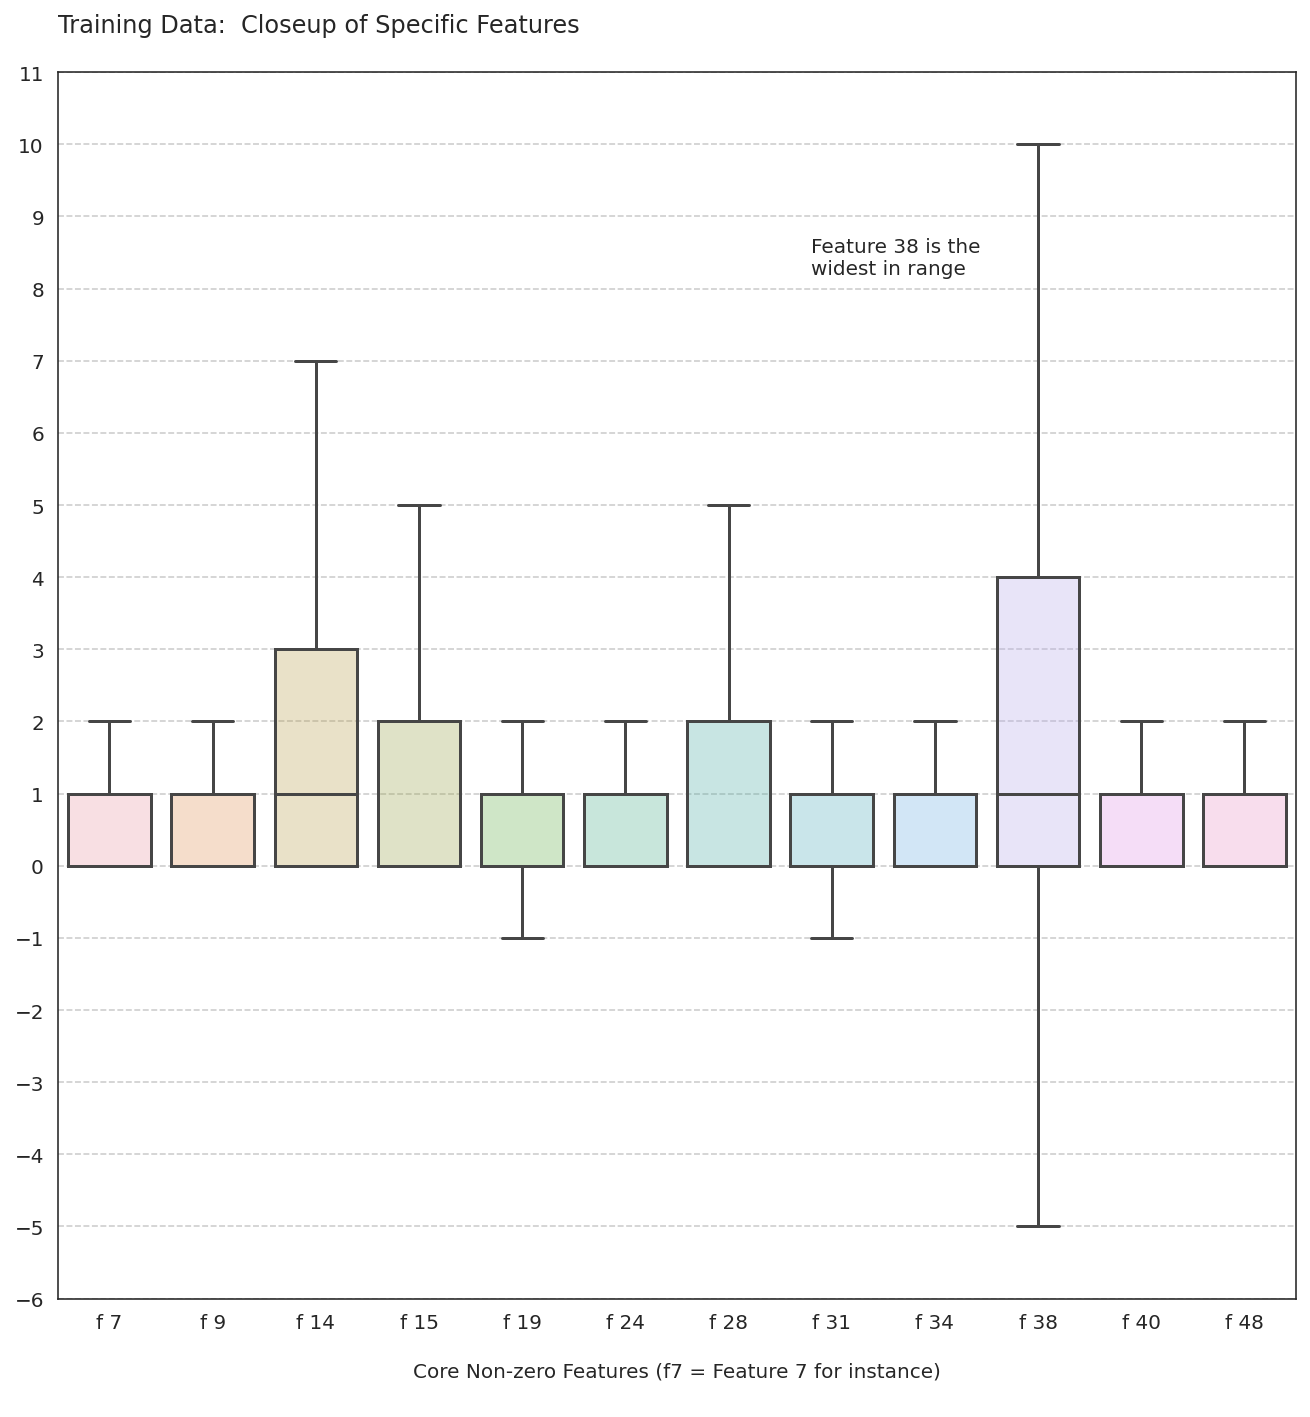

In [92]:
temp2 = temp.copy()

temp2 = temp2[ ['feature 7', 
                'feature 9', 
                'feature 14', 
                'feature 15', 
                'feature 19', 
                'feature 24', 
                'feature 28', 
                'feature 31', 
                'feature 34', 
                'feature 38', 
                'feature 40', 
                'feature 48']]
dff = temp2.copy()

flierprops = dict(markerfacecolor='0.75', 
                  markersize=.1,
                  linestyle='none')

fig, ax = plt.subplots(figsize=(9.2,10))
ax.set_ylim(-6, 11)
ax.set_title('Training Data:  Closeup of Specific Features\n', fontsize=12, loc='left')
sns.boxplot(data=dff,
            ax=ax,
            showfliers=False,
            width=.8,
            #color='blue'
            )
            #flierprops=flierprops)
#Completely hide tick markers...
# ax.yaxis.set_major_locator(plt.NullLocator())
# ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.yaxis.grid(True)   # Show the horizontal gridlines
ax.xaxis.grid(False)  # Hide x-axis gridlines 

ax.yaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_minor_locator(plt.MultipleLocator(5))

# Add transparency to colors
for patch in ax.artists:
  r, g, b, a = patch.get_facecolor()
  patch.set_facecolor((r, g, b, .3))
    
# ax.set(xlabel=''common xlabel', ylabel='common ylabel', title='some title')
ax.set(xlabel="\nCore Non-zero Features (f7 = Feature 7 for instance)\n")
ax.set(ylabel="")

ax.set_xticklabels(['f 7', 'f 9','f 14', 'f 15', 'f 19', 'f 24', 'f 28', 'f 31', 'f 34', 'f 38', 'f 40', 'f 48'])

# plt.title('My subtitle',fontsize=16)
# plt.suptitle('My title',fontsize=24, x=0, y=1,ha="left")
plt.text(x=6.8, y=8.2, s='Feature 38 is the\nwidest in range', fontsize=10)
# plt.text(x=4.7, y=4.6, s='The size of each point corresponds to sepal width', fontsize=8, alpha=0.75)
# ax.set(xlabel='common xlabel', ylabel='common ylabel', title='some title'

plt.tick_params(left=False)
plt.tick_params(bottom=False)

# plt.savefig('closeup_histogram.svg', dpi=300)
plt.tight_layout()
plt.show();

* Feature 38 appears to have the widest distribution, followed by Feature 14...
* Visualization of the above chart available [here](https://raw.githubusercontent.com/tombresee/XGBOOST/main/ENTER/closeup_histogram.svg)
* Below we will count the number of unique category values per individual feature.  We see that Feature_38 has 71 unique values, and Feature_14 has 52. 
* Overall, this is somewhat unusual data, appears to be a massive count of zero values in features...


In [93]:
tempd = train_df.copy()          
tempd.drop('id', axis=1, inplace=True)
tempd.drop('target', axis=1, inplace=True)
tempd = tempd.apply(lambda x: len(x.unique()))
#tempd = tempd.sort_values(ascending=False, inplace=True)
tempd = tempd.sort_values(ascending=False)
tempd = pd.DataFrame(tempd)
tempd.columns=['unique value count']
tempd.index.name = 'feature_id'
cm = sns.light_palette("blue", as_cmap=True)
tempd.style.set_caption('Num of unique values per Feature').background_gradient(cmap=cm)


,unique value count
feature_id,
feature 38,71
feature 39,70
feature 19,58
feature 14,52
feature 31,46
feature 48,45
feature 35,44
feature 30,43
feature 42,40


* Why did I plot the above ?  Because look at the bottom five features (Features 44, 2, 22, 36, 13).  They have extremely few unique values, out of 100,000 entries.  That has got to be some previous true categorical value encoded... but who knows.  Looking at the top, one has to think either those values are actually categories or possibly actually continuous variables of some form...
* So we need to look at the percentages (per feature) of the time the values are zero (below)

In [94]:
tempd = train_df.copy()          
tempd.drop('id', axis=1, inplace=True)
tempd.drop('target', axis=1, inplace=True)
tempd = tempd[tempd == 0].count(axis=0)/len(tempd.index)
tempd = tempd.sort_values(ascending=False)
tempd = pd.DataFrame(tempd)
tempd.columns=['% of values that are 0']
tempd.index.name = 'feature_id'
cm = sns.light_palette("blue", as_cmap=True)
#tempd.style.format("{:.2%}")
tempd.style.format("{:.1%}").set_caption('Percent of feature values equaling zero').background_gradient(cmap=cm)

,% of values that are 0
feature_id,
feature 13,94.9%
feature 2,93.5%
feature 44,93.3%
feature 29,91.4%
feature 27,91.2%
feature 36,91.1%
feature 32,90.4%
feature 5,90.2%
feature 1,89.0%


* So what do we see here ?  I would consider this is a somewhat unusual dataset, with a large percentage of zero valeus in some features.  Which really also means those features that have less percent of zero will be more 'impactful' in the model calculation one would suspect. We will keep our eye on feature_38 and feature_14 when we plot things like xgboost importance.  But what bothers me here is that overall there aren't that many actual values that are nonzero, so going to be somewhat hard to actually create an accurate model.  We need variation.  We have not that much. 

In [95]:
tempd = train_df.copy()          
tempd.drop('id', axis=1, inplace=True)
tempd.drop('target', axis=1, inplace=True)
# np.count_nonzero(tempd)
print ("Number of entries that are nonzero:    ", (tempd != 0).values.sum())
print ("Number of entries that are zero:       ", (tempd == 0).values.sum())
print ("Number of entries that are below zero: ", np.sum(tempd.values < 0))
print ("Total Number of entries in training df:", (tempd == 0).values.sum() + (tempd != 0).values.sum())

Number of entries that are nonzero:     1029716
Number of entries that are zero:        3970284
Number of entries that are below zero:  227
Total Number of entries in training df: 5000000


<div class="h3"><i>6. &ensp; XGBoost Model Creation</i></div> 

* In my case, we obviously want to create an XGBoost classifer (and not regressor)
* As a follow up, will look into when to use the objective function 'multi:softmax' vs 'multi:softprob' for multi-class problems like this, i'm still not convinced the documentation makes sense
* We have technically four classes, so i will specifically code the num_class (its not num_classes fyi) variable to 4 (remembering that that means the actual encoded targets MUST be 0,1,... num_class-1, i.e. [0,1,2,3]
* Need to dive in more to base_score, it is the initial prediction score of all instances, i.e. global bias but I want to undertand this mathematically, will draw it out...
* XGBoost (as well as other gradient boosting machine algs) have a number of parameters that can be tuned to avoid overfitting. For instance, max_depth can be set to avoid overfitting (in fact, the more, the more likely to overfit)
* I don't think most people know you can either use `eta` (formally documented in the xgboost docs) or what is technically an alias for eta, i.e. `learning_rate`. I know what eta is, but really how many people if you didn't tell them would be able to give you the greek symbol for it, much less know how to say $\eta$ correctly, so I will actually never use parameter eta, i will specifically call it out as learning_rate.  

* Upgraded xgboost library to very latest (**xgb version: 1.4.2**)

In [96]:
from io import StringIO

data = ("""

id,param,def_value,descr

1,base_score,0.5,initial prediction score of all instances

2,booster,gbtree,Can be gbtree gblinear or dart

3,num_estimates,100,number of estimates

4,max_depth, 6,maximum depth of a tree (too high a value leads to overfitting)

5, add, more, here

""")

mapper = pd.read_csv(StringIO(data))

d = dict(selector="th",
    props=[('text-align', 'center')])

mapper = mapper.set_index('id')

mapper.style.set_properties(**{'width':'9em', 'text-align':'center'})\
        .set_table_styles([d])

,param,def_value,descr
id,,,
1,base_score,0.5,initial prediction score of all instances
2,booster,gbtree,Can be gbtree gblinear or dart
3,num_estimates,100,number of estimates
4,max_depth,6,maximum depth of a tree (too high a value leads to overfitting)
5,add,more,here


In [97]:
# basically redoing things to be safe:
train = pd.read_csv('../input/tabular-playground-series-may-2021/train.csv')
test = pd.read_csv('../input/tabular-playground-series-may-2021/test.csv')
sample_submission = pd.read_csv('../input/tabular-playground-series-may-2021/sample_submission.csv') 
le = LabelEncoder() # practice, i could do it manually if i wanted... 
train.target = le.fit_transform(train.target)
features = train.columns[1:51] # only fifty 
X_train, X_val, y_train, y_val = train_test_split(train.drop(columns=["id","target"]), train.target, stratify=train.target)
# y_train = y_train.map({'Class_1':0, 
#                        'Class_2':1, 
#                        'Class_3':2, 
#                        'Class_4':3})

* I will use bst versus clf naming notation, per the XGBoost documentation to maintain consistency

In [98]:
# at one point i actually wanted to 
# encode the target classes to be 
# 1,2,3,4 to match their names (and 
# not 0,1,2,3) but don't do that :) 

# i will create a base xgboost classifier, 
# but will specifically call out all of the 
# default parameters to explain what they
# actually do. 
#
# later, i will tweak...

bst = xgb.XGBClassifier(\
base_score=0.5, 
booster='gbtree', 
colsample_bylevel=1,
colsample_bynode=1, 
colsample_bytree=1,
# set during training ?  
# eval_metric="mlogloss",
gamma=0,
gpu_id=-1,
importance_type='gain', 
interaction_constraints='',
learning_rate=0.2,
max_delta_step=0, 
#max_depth=6 (def)
max_depth=3, 
min_child_weight=1, 
monotone_constraints='()',
# n_estimators=100 (def)
n_estimators=400, # 4 x def
n_jobs=4, 
num_class=4, # < - - 
num_parallel_tree=1,
objective='multi:softmax', 
# objective='multi:softprob',                
random_state=42, 
reg_alpha=0,
reg_lambda=1, 
scale_pos_weight=None,
subsample=1,
tree_method='exact', 
use_label_encoder=False,
# validate_parameters=1,
verbosity=0)

bst.fit(X_train,
y_train,
verbose=False,
eval_metric=['mlogloss'],
# multiclass logloss...
# already default with latest release
# early_stopping_rounds=10,
# initial attempt at early stopping, 
# hold for now
)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=4, num_class=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

* I will use bst versus clf naming notation, per the XGBoost documentation to maintain consistency

<pre style="font-family:Consolas; font-size:.7em">
--- OUTPUT FROM MODEL CREATION: ---

XGBClassifier(
base_score=0.5, 
booster='gbtree', 
colsample_bylevel=1,
colsample_bynode=1, 
colsample_bytree=1, 
gamma=0,
gpu_id=-1,
importance_type='gain', 
interaction_constraints='',
learning_rate=0.2, 
max_delta_step=0, 
max_depth=3,
min_child_weight=1, 
missing=nan, 
monotone_constraints='()',
n_estimators=400, 
n_jobs=4, 
num_class=4, 
num_parallel_tree=1,
objective='multi:softprob', 
random_state=42, 
reg_alpha=0,
reg_lambda=1, 
scale_pos_weight=None, 
subsample=1,
tree_method='exact', 
use_label_encoder=False,
validate_parameters=1, 
verbosity=0)
</pre>

[click here to see verbose run output, easier to view](https://raw.githubusercontent.com/tombresee/XGBOOST/main/ENTER/proto_run.txt)


* Let's say you are a relatively motivated person and wanted to review every iteration of the model and all of its parameters, you could do something like this below.  Save the model as a json file.  Open that json file and convert the contents to a python dictionary, and you are on your way...

In [99]:
bst.save_model('mark_I.json')

# --- if you want to download file from kaggle ---
# import os 
# os.chdir(r'/kaggle/working')
# from IPython.display import FileLink 
# FileLink(r'mark_I.json')
# to download it and look at it on github

with open('mark_I.json') as json_file:
    blueprint = json.load(json_file)
    # now we have the model in python dictionary form

In [100]:
blueprint['learner']['gradient_booster']['model']['trees'][0].keys()

dict_keys(['base_weights', 'categories', 'categories_nodes', 'categories_segments', 'categories_sizes', 'default_left', 'id', 'left_children', 'loss_changes', 'parents', 'right_children', 'split_conditions', 'split_indices', 'split_type', 'sum_hessian', 'tree_param'])

* **blueprint['learner']['feature_names']** &ensp;  feature_0 thru feature_49
* **blueprint['learner']['feature_types']** &ensp;  feature dtypes, i.e. int
* **blueprint['learner']['gradient_booster']['model'].keys()** &ensp; 'gbtree_model_param', 'tree_info', 'trees'
* **len(blueprint['learner']['gradient_booster']['model']['trees'])** &ensp; 1600
* **blueprint['learner']['gradient_booster']['model']['trees'][0]** &ensp; first tree metadata (shown below)
* **blueprint['learner']['gradient_booster']['model']['trees'][0].keys()** &ensp; ['base_weights', 'categories', 'categories_nodes', 'categories_segments', 'categories_sizes', 'default_left', 'id', 'left_children', 'loss_changes', 'parents', 'right_children', 'split_conditions', 'split_indices', 'split_type', 'sum_hessian', 'tree_param']  < - - - now we are talkin' ! ! ! 
* now we have molecular level tree data...


* show me the **first tree's** molecular data (you also see how you can open the dict to various keys to get precisely what you want):

In [101]:
blueprint['learner']['gradient_booster']['model']['trees'][0]

{'base_weights': [-0.44026878,
  -0.44037783,
  0.24390244,
  -0.44043988,
  0.5882353,
  0.62068963,
  -0.4,
  -0.441674,
  -0.3820034,
  0.8,
  0.11764706],
 'categories': [],
 'categories_nodes': [],
 'categories_segments': [],
 'categories_sizes': [],
 'default_left': [True,
  True,
  True,
  True,
  False,
  True,
  False,
  False,
  False,
  False,
  False],
 'id': 0,
 'left_children': [1, 3, 5, 7, -1, 9, -1, -1, -1, -1, -1],
 'loss_changes': [2.2050781,
  2.0546875,
  1.4916737,
  1.8588867,
  0.0,
  0.23286009,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'parents': [2147483647, 0, 0, 1, 1, 2, 2, 3, 3, 5, 5],
 'right_children': [2, 4, 6, 8, -1, 10, -1, -1, -1, -1, -1],
 'split_conditions': [10.5,
  42.5,
  0.5,
  4.5,
  0.11764707,
  0.5,
  -0.080000006,
  -0.0883348,
  -0.07640068,
  0.16000001,
  0.023529412],
 'split_indices': [29, 31, 9, 45, 0, 3, 0, 0, 0, 0, 0],
 'split_type': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'sum_hessian': [28125.0,
  28120.875,
  4.125,
  28119.75,
  1.125,
 

We will look more into this shortly...

<div class="h3"><i>7. &ensp; Feature Importance</i></div>  

* XGBoost actually has a built in `plot_importance` function that is relatively useful, but its default visualization is somewhat unappealing.  The actual values are contained within ```your_model.feature_importances_``` (after you train the model obviously)
* Just printing out the feature importances, you see abc `print(mymodel.feature_importances_)`

In [102]:
bst.get_params(deep=True)

{'objective': 'multi:softprob',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.2,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 400,
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': 0,
 'num_class': 4}

In [103]:
bst.get_xgb_params()

{'objective': 'multi:softprob',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'interaction_constraints': '',
 'learning_rate': 0.2,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': 0,
 'num_class': 4}

In [104]:
bst.feature_importances_

array([0.02089373, 0.01999038, 0.05297024, 0.01530234, 0.01560577,
       0.02428557, 0.02477244, 0.0146523 , 0.01314729, 0.0174    ,
       0.0198606 , 0.02263389, 0.0185178 , 0.04933963, 0.02180015,
       0.02198968, 0.02112427, 0.01412496, 0.01589468, 0.01510204,
       0.01697171, 0.01316344, 0.02503456, 0.01598089, 0.01665646,
       0.01733446, 0.01758482, 0.01692317, 0.02022411, 0.02184187,
       0.02236675, 0.01742223, 0.02863043, 0.01798693, 0.02151336,
       0.0159951 , 0.02911327, 0.01911096, 0.01691262, 0.01858394,
       0.01566258, 0.01345095, 0.02215932, 0.01851932, 0.02038556,
       0.01563285, 0.01454646, 0.01749248, 0.01662519, 0.01676639],
      dtype=float32)

* bst.classes_:  *array([0, 1, 2, 3])*
* Actual type of the bst instance is:  *xgboost.sklearn.XGBClassifier*
* bst.n_features_in_:  *50*

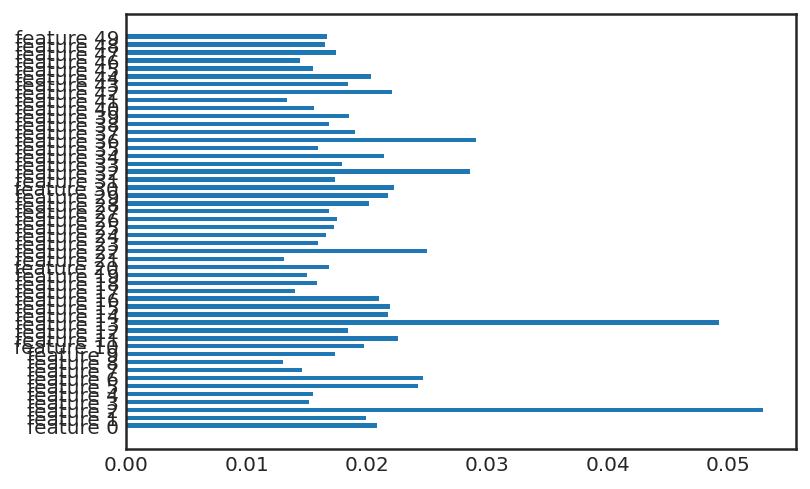

In [105]:
plt.style.use('seaborn-white')


feature_names = ['feature 0', 'feature 1', 'feature 2', 'feature 3', 'feature 4',
       'feature 5', 'feature 6', 'feature 7', 'feature 8', 'feature 9',
       'feature 10', 'feature 11', 'feature 12', 'feature 13', 'feature 14',
       'feature 15', 'feature 16', 'feature 17', 'feature 18', 'feature 19',
       'feature 20', 'feature 21', 'feature 22', 'feature 23', 'feature 24',
       'feature 25', 'feature 26', 'feature 27', 'feature 28', 'feature 29',
       'feature 30', 'feature 31', 'feature 32', 'feature 33', 'feature 34',
       'feature 35', 'feature 36', 'feature 37', 'feature 38', 'feature 39',
       'feature 40', 'feature 41', 'feature 42', 'feature 43', 'feature 44',
       'feature 45', 'feature 46', 'feature 47', 'feature 48', 'feature 49']
    
plt.barh(feature_names, bst.feature_importances_); 


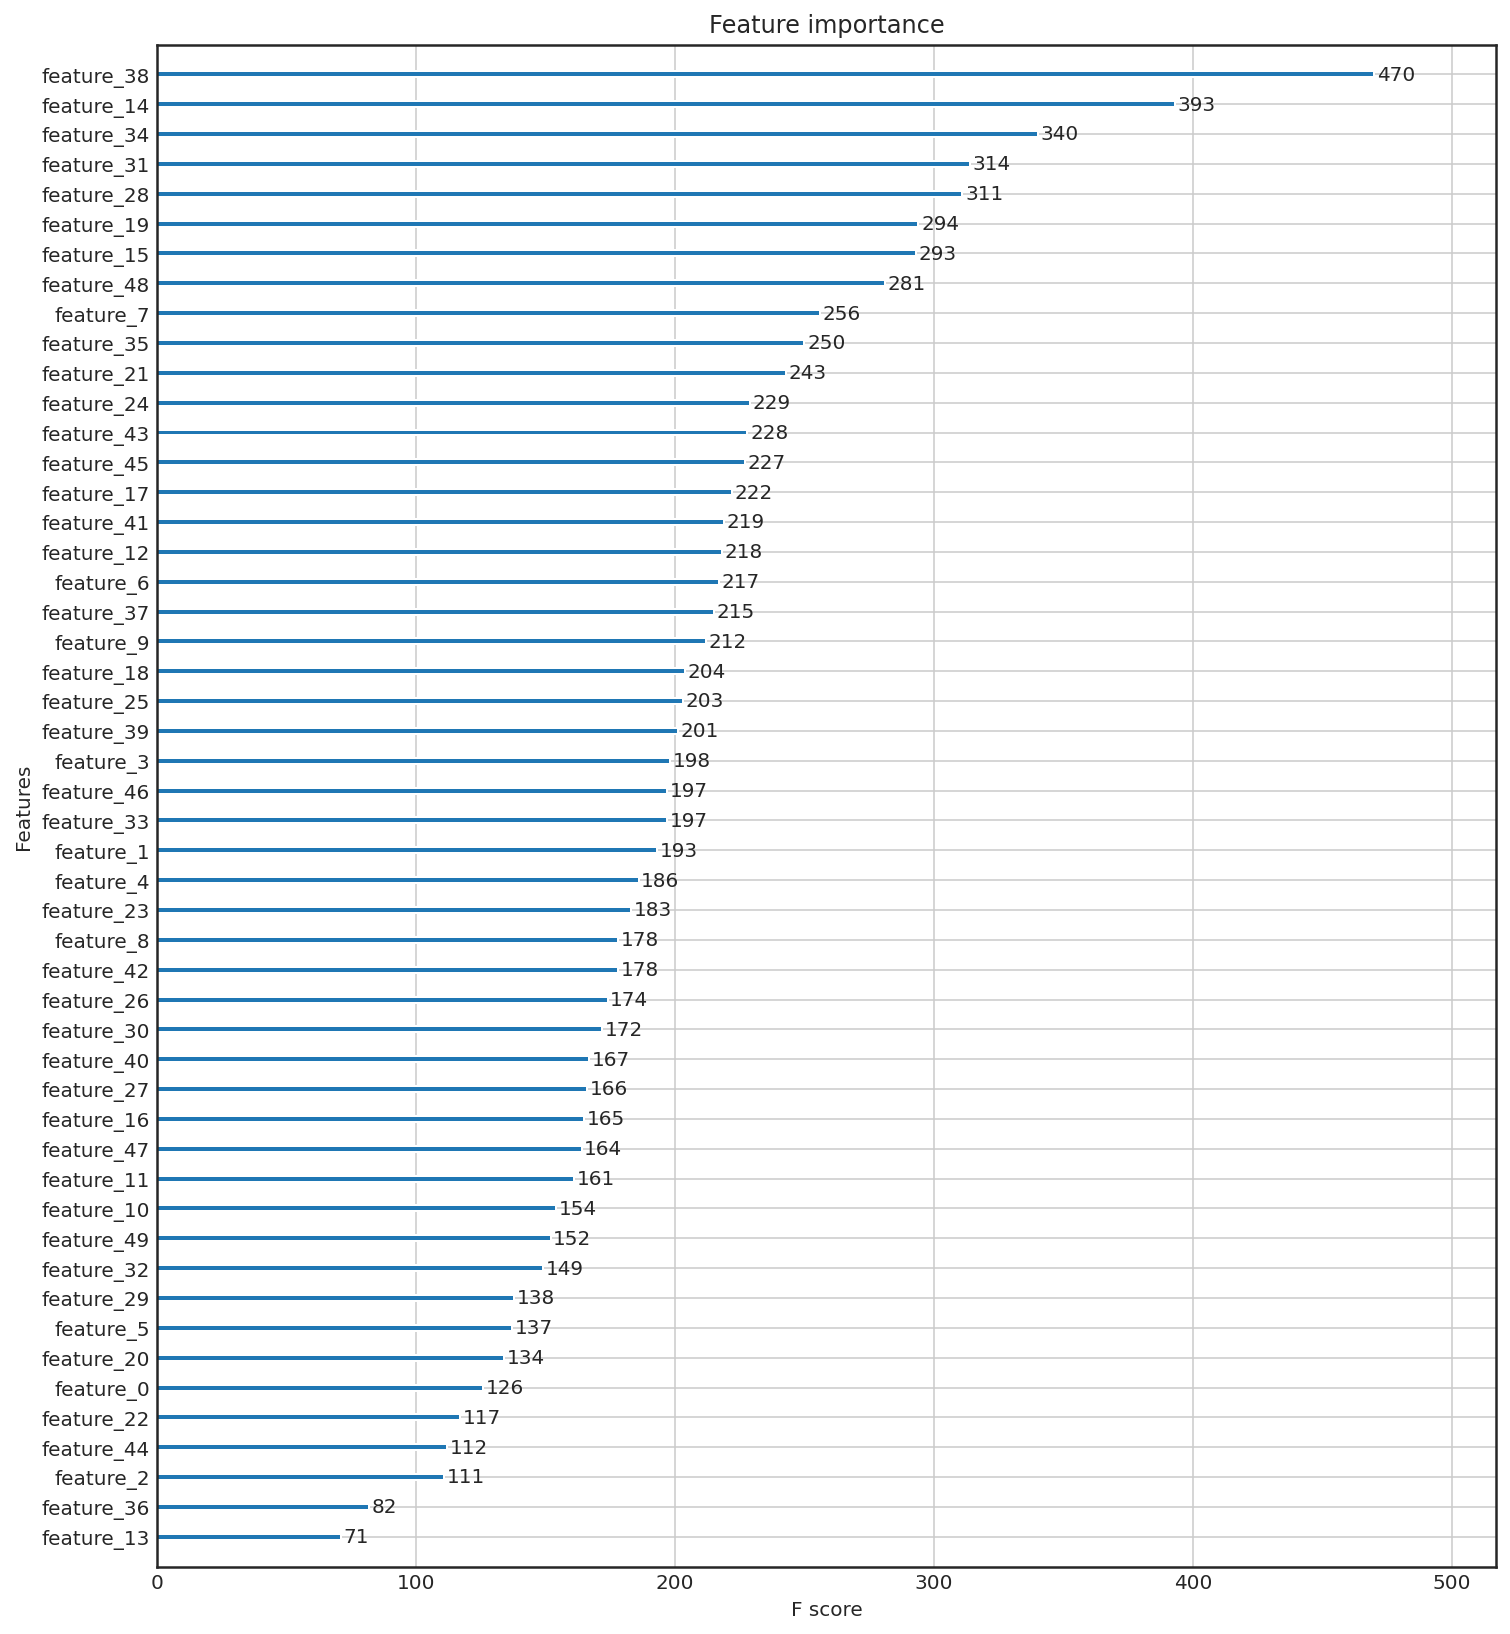

In [106]:
preds = bst.predict(X_val) 
preds_sub = bst.predict_proba(X_test)
fig, ax = plt.subplots(figsize=(12, 14))
xgb.plot_importance(bst, ax=ax); 
# fix, this is not pretty (use altair)

# plt.style.use('seaborn-white')
# preds = bst.predict(X_val) 
# preds_sub = bst.predict_proba(X_test)
# fig, ax = plt.subplots(figsize=(12, 14))
# xgb.plot_importance(bst, ax=ax); 
# # fix, this is not pretty (use altair)

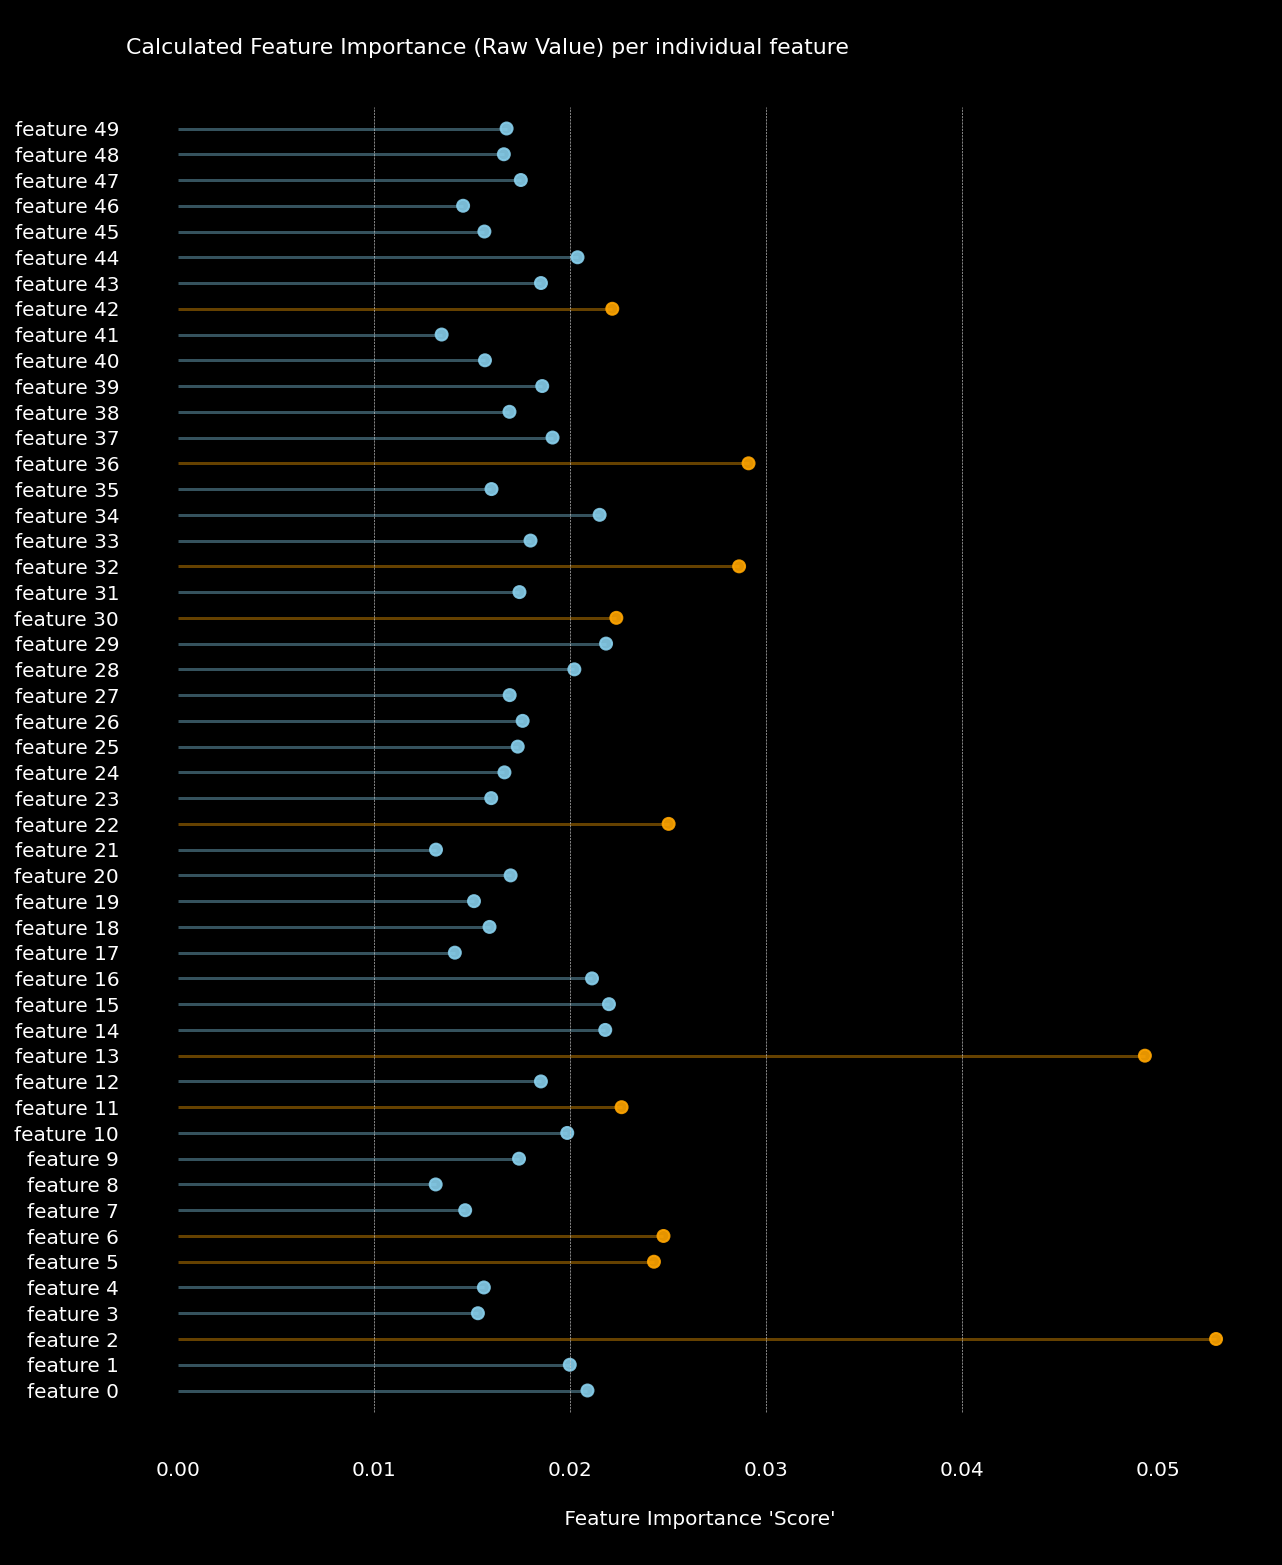

In [107]:
# plt.style.use('seaborn-white')

feature_names = ['feature 0', 'feature 1', 'feature 2', 'feature 3', 'feature 4',
       'feature 5', 'feature 6', 'feature 7', 'feature 8', 'feature 9',
       'feature 10', 'feature 11', 'feature 12', 'feature 13', 'feature 14',
       'feature 15', 'feature 16', 'feature 17', 'feature 18', 'feature 19',
       'feature 20', 'feature 21', 'feature 22', 'feature 23', 'feature 24',
       'feature 25', 'feature 26', 'feature 27', 'feature 28', 'feature 29',
       'feature 30', 'feature 31', 'feature 32', 'feature 33', 'feature 34',
       'feature 35', 'feature 36', 'feature 37', 'feature 38', 'feature 39',
       'feature 40', 'feature 41', 'feature 42', 'feature 43', 'feature 44',
       'feature 45', 'feature 46', 'feature 47', 'feature 48', 'feature 49']
    
# plt.barh(feature_names, bst.feature_importances_); 

plt.style.use('dark_background')

# df04 = tf.groupby('PossessionTeam')['Yards'].agg(sum).sort_values(ascending=True)
# df04 = pd.DataFrame(df04)
# df04['group'] = df04.index

my_range=range(0,50)
my_size=range(0,50)
# my_color = 'skyblue'
orb_size = [.8]*50

# my_size = [1] *50 

fig, ax = plt.subplots(figsize=(9,11))

# Create a color if the group is "B"
my_color=np.where(bst.feature_importances_ > 0.022, 'orange', 'skyblue')

# my_color=np.where(df04[  ('group'=='NE') | ('group'=='NO')  ], 'orange', 'skyblue')

# original code:  my_color=np.where( (df04.group == 'NE') | (df04.group == 'NO') | (df04.group == 'LA') , 'orange', 'skyblue')

##movies[(movies.duration >= 200) | (movies.genre == 'Drama')]
##df04[(df04.group == 'NE') | (df04.group == 'NO') ]
##(movies.duration >= 200) & (movies.genre == 'Drama')

# original code:  my_size=np.where(df04['group']=='B', 70, 30)
 
# original code:  plt.hlines(y=my_range, xmin=0, xmax=df04['Yards'], color=my_color, alpha=0.4)
# backup:         plt.hlines(y=feature_names , xmin=0, xmax=df04['Yards'], color=my_color, alpha=0.4)
plt.hlines(y=feature_names , xmin=0, xmax= bst.feature_importances_, color=my_color, alpha=0.4)

# original code:  plt.scatter(df04.Yards, my_range, color=my_color, s=my_size, alpha=1)
# plt.scatter(bst.feature_importances_, my_range, color="orange", s=my_size, alpha=1)
# plt.scatter(bst.feature_importances_, my_range, color=my_color, s=my_size, alpha=1)

plt.scatter(bst.feature_importances_, my_range, color=my_color, alpha=.9)

# plt.yticks(my_range, df04.group)

plt.title("\nCalculated Feature Importance (Raw Value) per individual feature", loc='left', fontsize=11)
plt.xlabel("\n Feature Importance 'Score'\n", fontsize=10)
plt.ylabel('')
ax.spines['top'].set_linewidth(.3)  
ax.spines['left'].set_linewidth(.3)  
ax.spines['right'].set_linewidth(.3)  
ax.spines['bottom'].set_linewidth(.3)  
sns.despine(top=True, right=True, left=True, bottom=True)
plt.axvline(x=0.01, color='lightgrey', ymin = .03, ymax=.97, linestyle="--", linewidth=.3)
plt.axvline(x=0.02, color='lightgrey', ymin = .03, ymax=.97, linestyle="--", linewidth=.3)
plt.axvline(x=0.03, color='lightgrey', ymin = .03, ymax=.97, linestyle="--", linewidth=.3)
plt.axvline(x=0.04, color='lightgrey', ymin = .03, ymax=.97, linestyle="--", linewidth=.3)
plt.tight_layout()
plt.show();


* **Note:** &ensp; There is a difference between 'feature importance' and XGBoost's feature importance plot (which is actually based on F-Score)

<div class="h3"><i>8. &ensp; Plotting Decision Trees</i></div> 


* Let's plot the first decision tree here (top down view):

In [108]:
# xgb.plot_tree(\
# bst, 
# num_trees=0,
# plot_width = 50,
# plot_height = 50,
# render = True,
# show_node_id=True, 
# )
# fig = matplotlib.pyplot.gcf()
# fig.set_size_inches(100, 100)
# # fig.savefig('tree.svg')


# xgb.plot_tree(bst)
# fig = matplotlib.pyplot.gcf()
# fig.set_size_inches(22,11)

# xgb.plot_tree(bst, num_trees=4); plt.show()
# xgb.plot_tree(bst, num_trees=0, rankdir='LR'); plt.show()
    


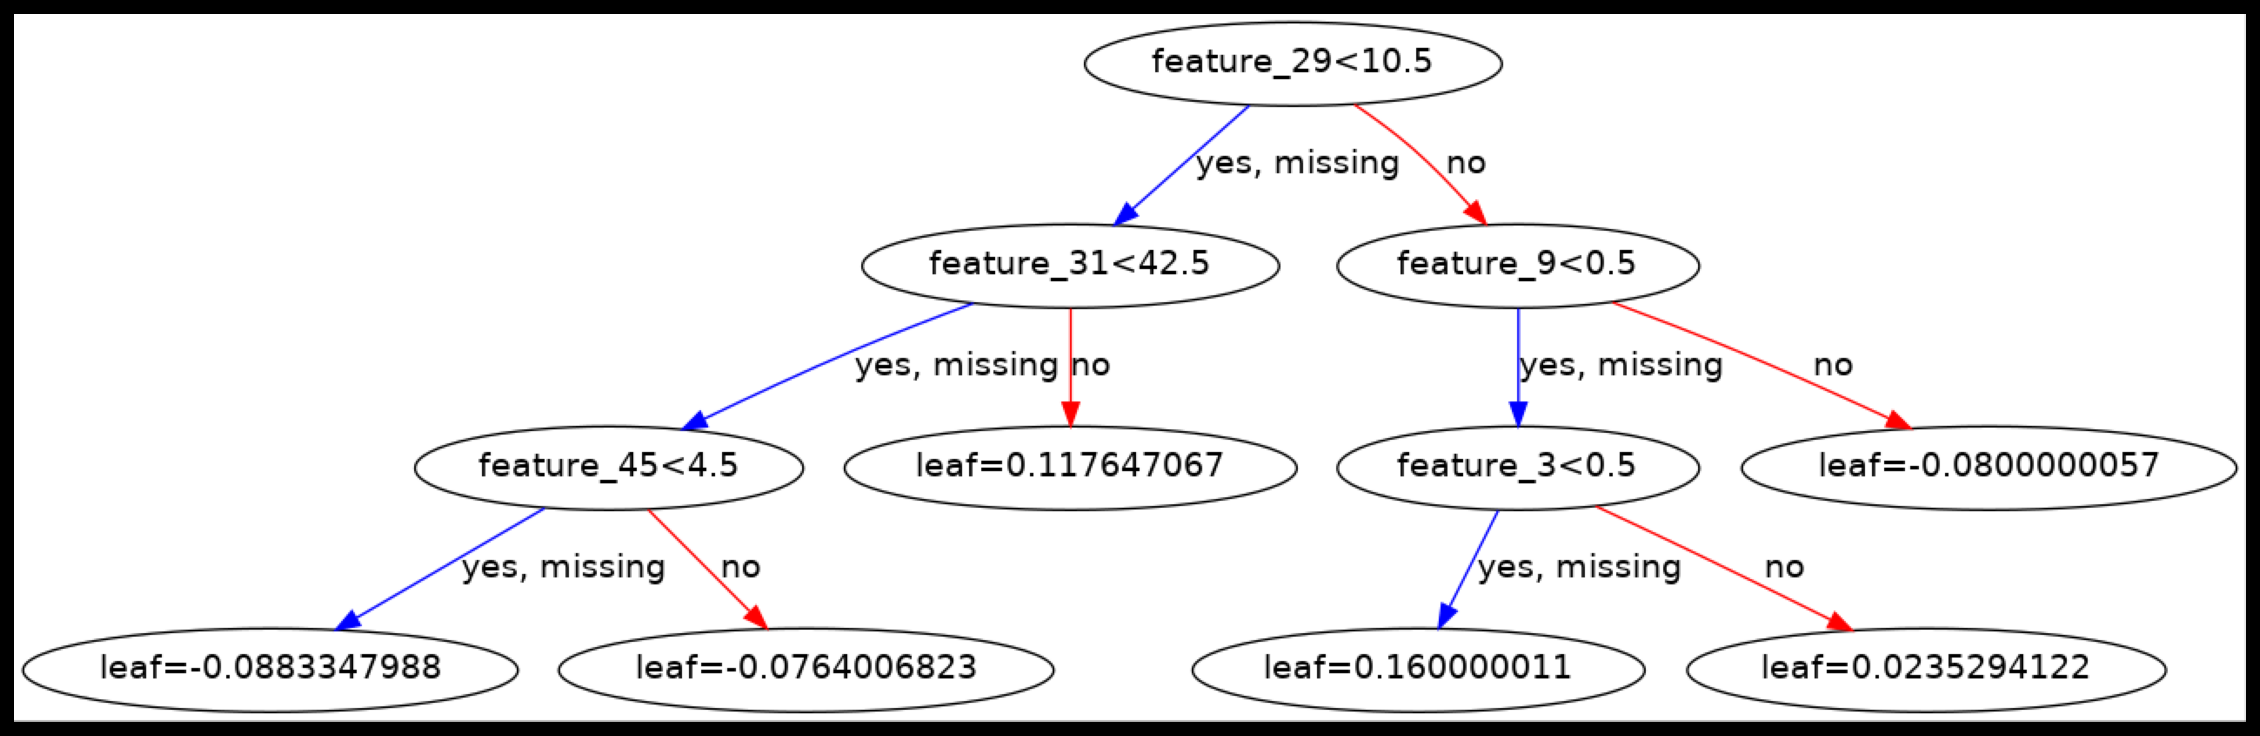

In [109]:
xgb.plot_tree(bst, num_trees=0)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20,20)
fig.savefig('tree.svg')

# later can use:
# import os
# os.chdir(r'/kaggle/working')
# from IPython.display import FileLink 
# FileLink(r'tree.svg')

STOP FOR A SECOND: let's see if we can get this data another way...and really understand XGBOOST ! 

We will use our json model data we pulled earlier, and see now if we can reverse-engineer the parameters in that blueprint-type json file ...

If we enter:  `blueprint['learner']['gradient_booster']['model']['trees'][0]['split_indices']`, we get output: `[23, 29, 7, 26, 14, 37, 0, 0, 0, 0, 0, 0, 0]`

Now we look at our plot above, and bam we get it now:  first split is at `23` i.e. feature_23 (and you see in the plot), and second split is at `29`, i.e. feature_29 (upper left of plot), and to the right of that we see `7` i.e. feature_7 (upper right in plot), and on down to feature_`26`, feature_`14`, feature_`37`, and then we stop (three levels stopped). 

If we enter:  `blueprint['learner']['gradient_booster']['model']['trees'][0]['split_conditions']`, we get output:  `[0.5, 10.5, 23.5, 16.5, 0.5, 11.5, 0.12173913, -0.08919667, -0.018791948, -0.0, 0.16000001, -0.08308835, 0.06315789]`.  See if you can see those numbers in the plot. And then it hits you, they are the spliting conditions (shown physically inside the circles), i.e the first feature (feature_23) is split on the first split point (0.5), and the second feature (feature_29) is split on the second split_condition (10.5), etc etc. 

If we enter:  `blueprint['learner']['gradient_booster']['model']['trees'][0]['tree_param']['num_nodes']`, we see output `13`.  Count the total number of nodes, you see 13 right ?

Seven 'left' nodes, seven 'right' nodes.  node index for even:  2, 4, 6, 8, 10, 12, 14. node index for odd: 1, 3, 5, 7, 9, 11, 13. 

In [110]:
blueprint['learner']['gradient_booster']['model']['trees'][0].keys()

dict_keys(['base_weights', 'categories', 'categories_nodes', 'categories_segments', 'categories_sizes', 'default_left', 'id', 'left_children', 'loss_changes', 'parents', 'right_children', 'split_conditions', 'split_indices', 'split_type', 'sum_hessian', 'tree_param'])

In [111]:
blueprint['learner']['gradient_booster']['model']['trees'][0]['split_indices']

[29, 31, 9, 45, 0, 3, 0, 0, 0, 0, 0]

In [112]:
blueprint['learner']['gradient_booster']['model']['trees'][0]['split_conditions']

[10.5,
 42.5,
 0.5,
 4.5,
 0.11764707,
 0.5,
 -0.080000006,
 -0.0883348,
 -0.07640068,
 0.16000001,
 0.023529412]

In [113]:
blueprint['learner']['gradient_booster']['model']['trees'][0]['tree_param']['num_nodes']

'11'

In [114]:
blueprint['learner']['gradient_booster']['model']['trees'][0]['base_weights']
# base weight, before learning rate

[-0.44026878,
 -0.44037783,
 0.24390244,
 -0.44043988,
 0.5882353,
 0.62068963,
 -0.4,
 -0.441674,
 -0.3820034,
 0.8,
 0.11764706]

In [115]:
blueprint['learner']['gradient_booster']['model']['trees'][0]

{'base_weights': [-0.44026878,
  -0.44037783,
  0.24390244,
  -0.44043988,
  0.5882353,
  0.62068963,
  -0.4,
  -0.441674,
  -0.3820034,
  0.8,
  0.11764706],
 'categories': [],
 'categories_nodes': [],
 'categories_segments': [],
 'categories_sizes': [],
 'default_left': [True,
  True,
  True,
  True,
  False,
  True,
  False,
  False,
  False,
  False,
  False],
 'id': 0,
 'left_children': [1, 3, 5, 7, -1, 9, -1, -1, -1, -1, -1],
 'loss_changes': [2.2050781,
  2.0546875,
  1.4916737,
  1.8588867,
  0.0,
  0.23286009,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'parents': [2147483647, 0, 0, 1, 1, 2, 2, 3, 3, 5, 5],
 'right_children': [2, 4, 6, 8, -1, 10, -1, -1, -1, -1, -1],
 'split_conditions': [10.5,
  42.5,
  0.5,
  4.5,
  0.11764707,
  0.5,
  -0.080000006,
  -0.0883348,
  -0.07640068,
  0.16000001,
  0.023529412],
 'split_indices': [29, 31, 9, 45, 0, 3, 0, 0, 0, 0, 0],
 'split_type': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'sum_hessian': [28125.0,
  28120.875,
  4.125,
  28119.75,
  1.125,
 

So now lets get fancy:

In [116]:
print("\nFor the 191st decision tree, we see", blueprint['learner']['gradient_booster']['model']['trees'][190]['tree_param']['num_nodes'], "nodes")
print("We also see that the first split condition value was", blueprint['learner']['gradient_booster']['model']['trees'][190]['split_conditions'][0])
print("We also see that the third split condition value was", blueprint['learner']['gradient_booster']['model']['trees'][190]['split_conditions'][2])
print("We also see that the fourth split condition value was", blueprint['learner']['gradient_booster']['model']['trees'][190]['split_conditions'][3], "\n")


For the 191st decision tree, we see 15 nodes
We also see that the first split condition value was 6.5
We also see that the third split condition value was 27.5
We also see that the fourth split condition value was 1.5 



---

* It's not very clear in the name, but reading the documentation  you see that `num_trees` (which obviously grammatically is plural) is actually the exact tree (singular) you want to see (0-based).  Effectively this is specifying the ordinal number of the target tree.  

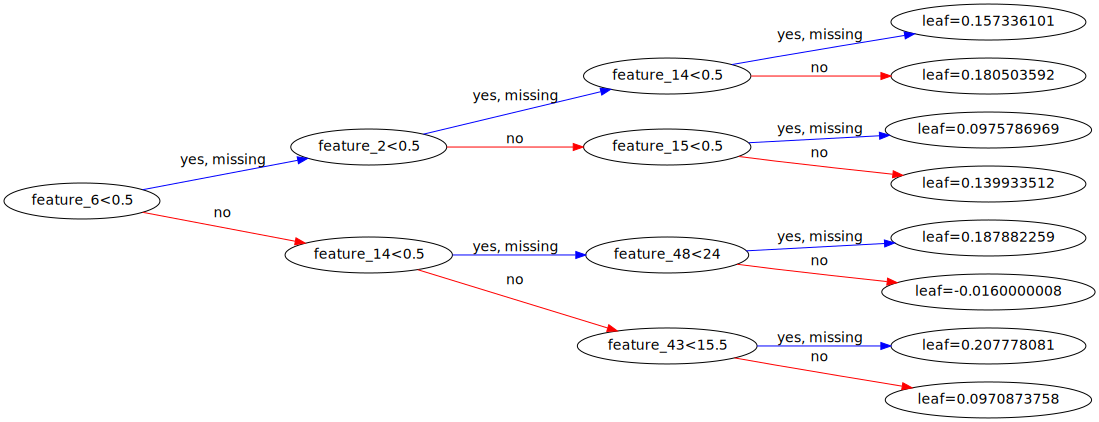

In [117]:
xgb.to_graphviz(bst, num_trees=1, rankdir='LR') 
# second tree, left right format... 

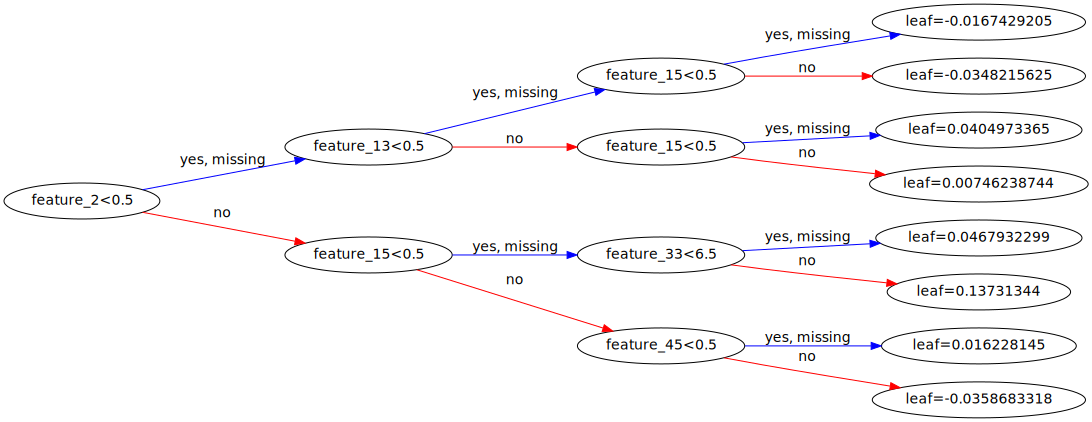

In [118]:
xgb.to_graphviz(bst, num_trees=2, rankdir='LR') 
# third tree 

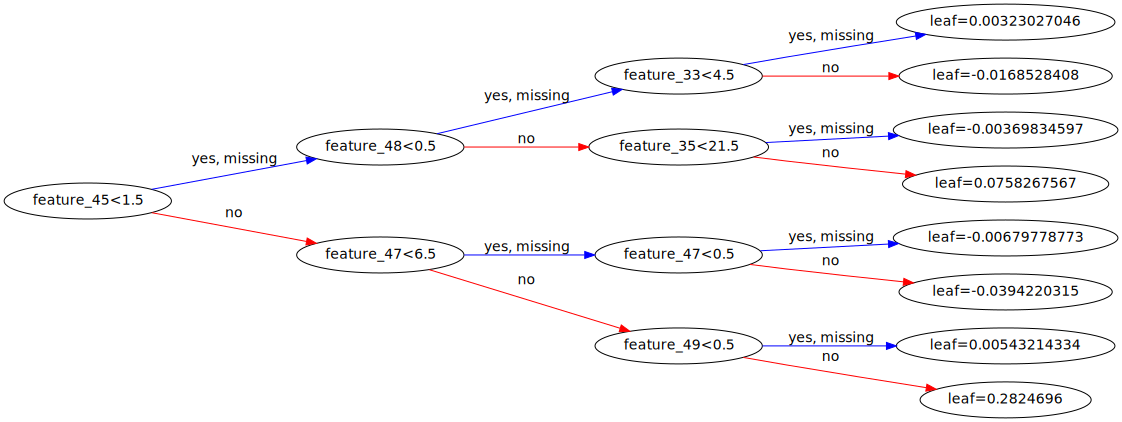

In [119]:
xgb.to_graphviz(\
bst, 
num_trees=299, 
rankdir='LR') 
# LAST tree (300-1) i.e. 299

* or we can get fancy and loop thru the first 10 trees for understanding:

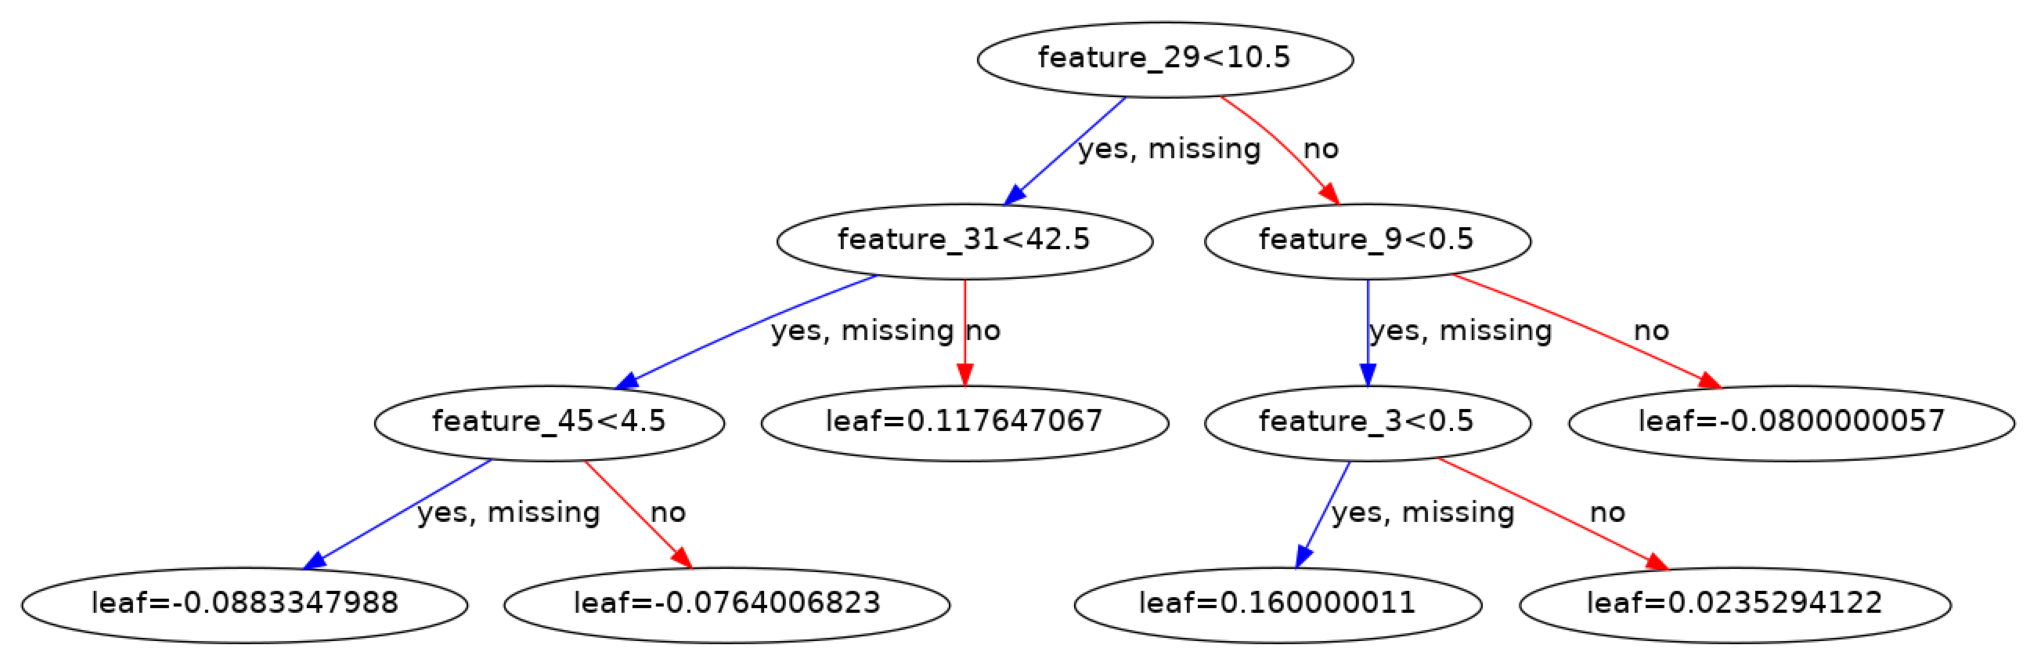

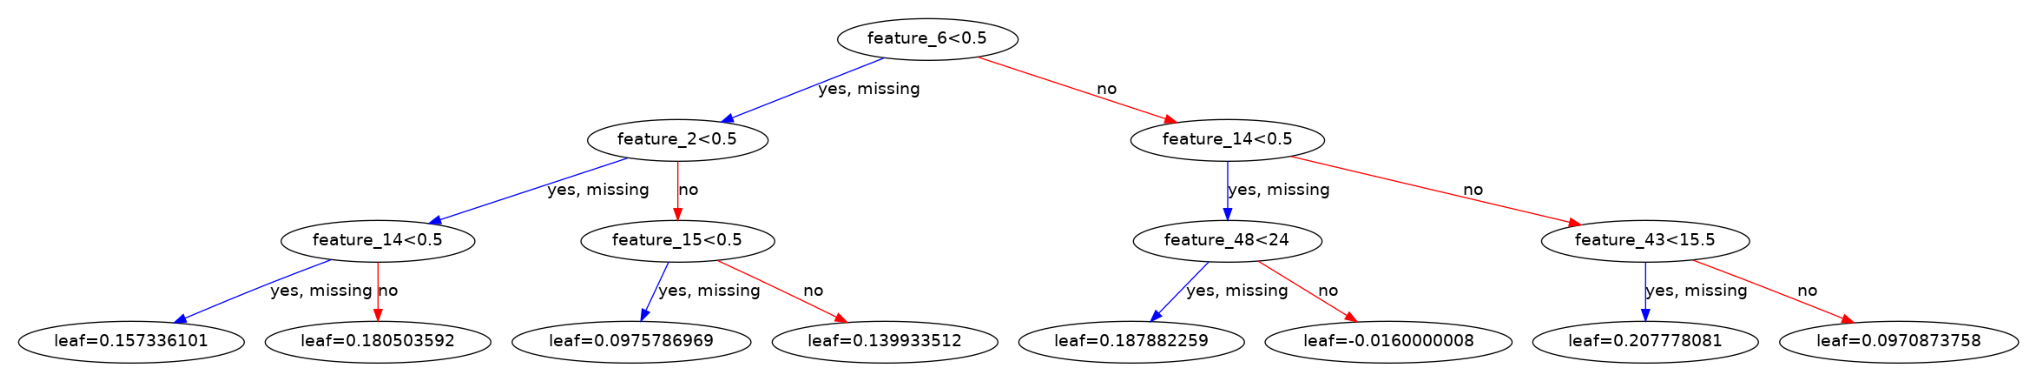

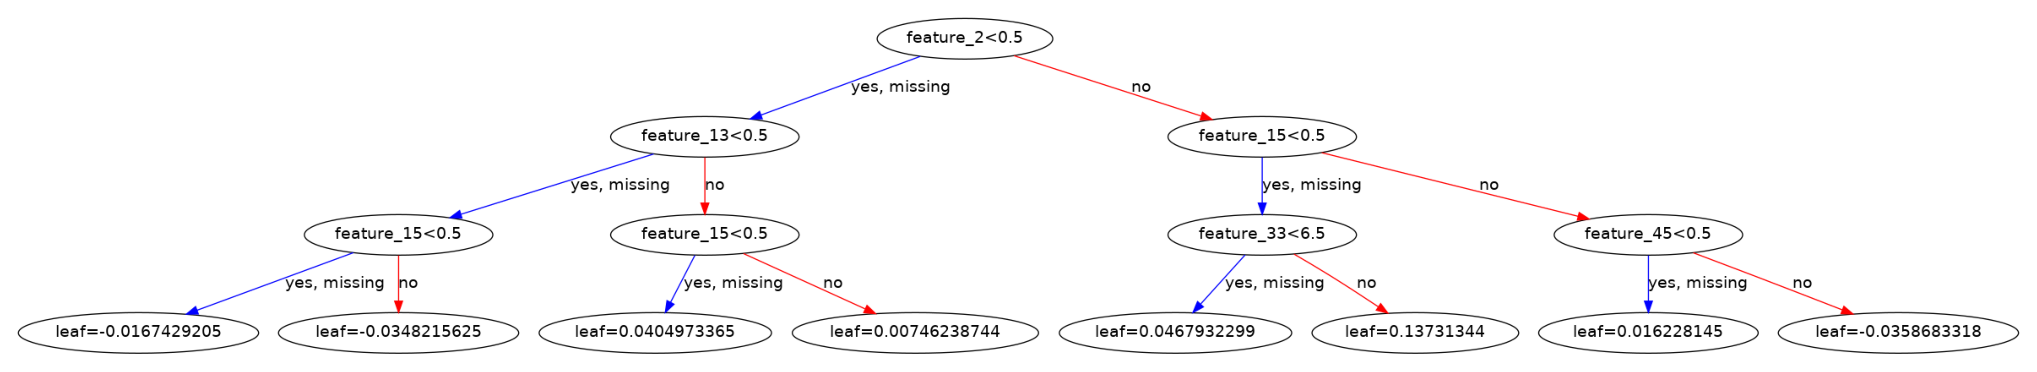

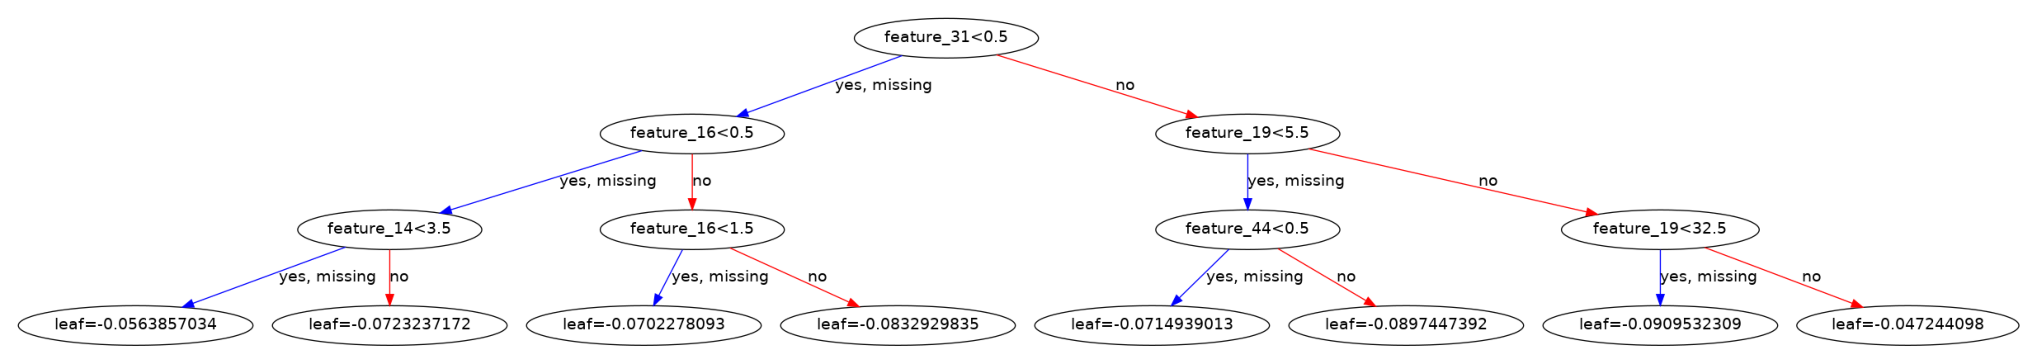

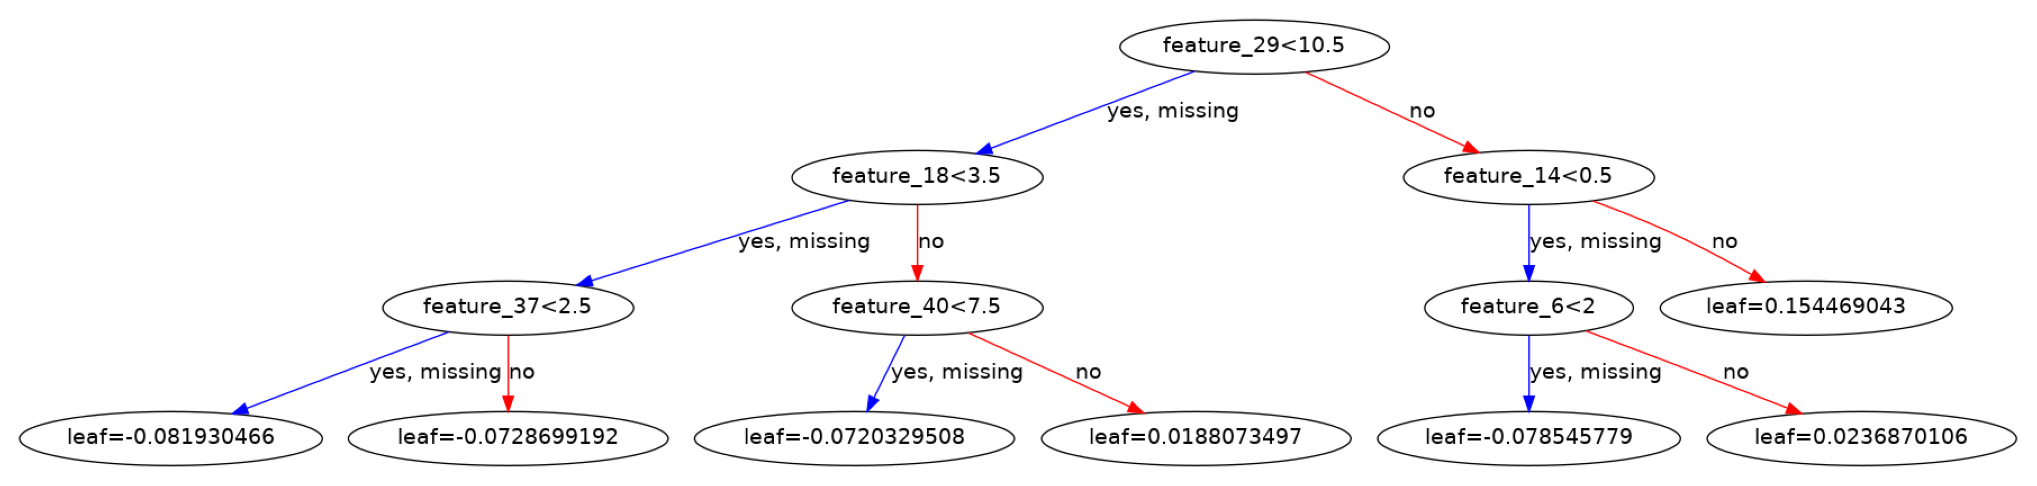

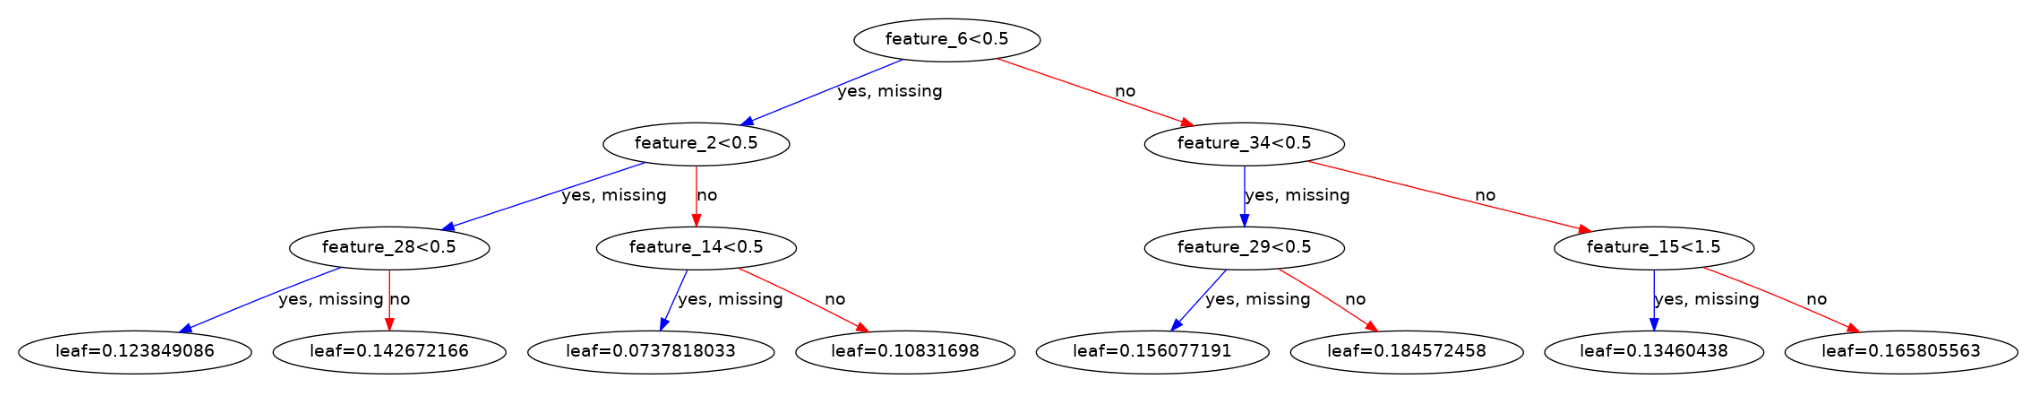

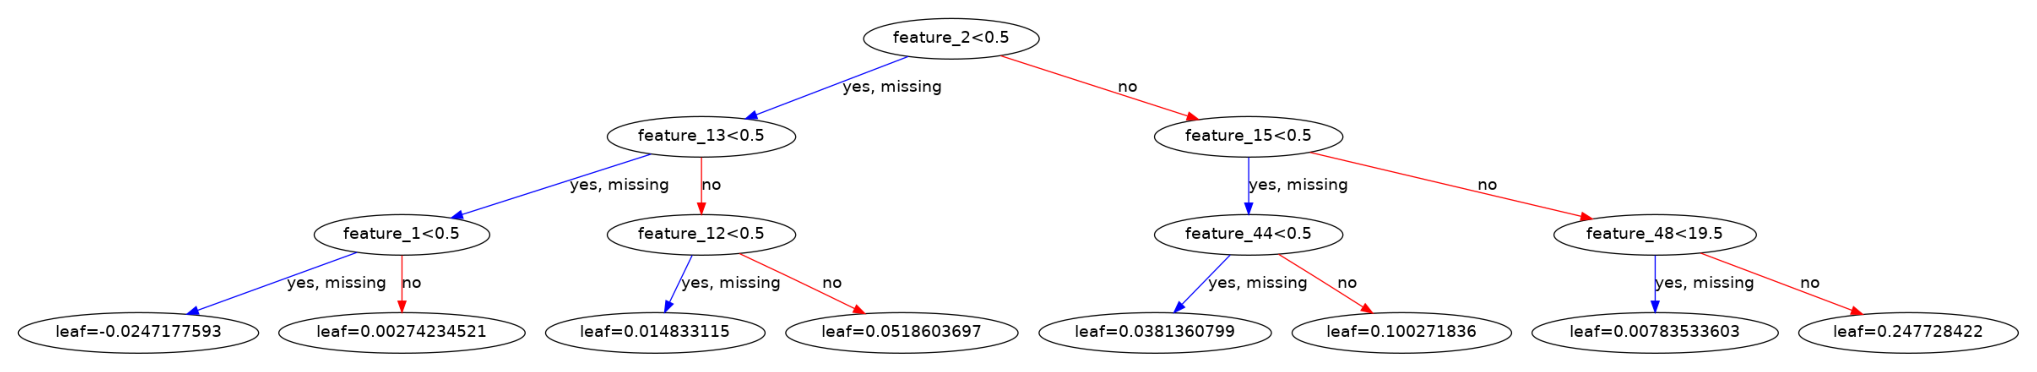

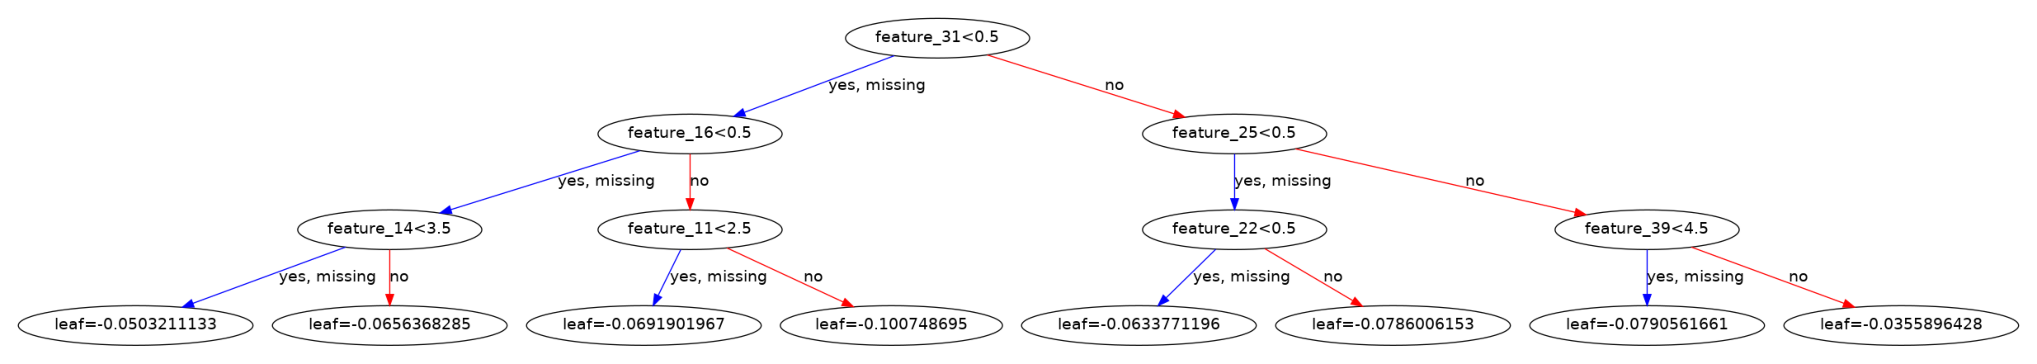

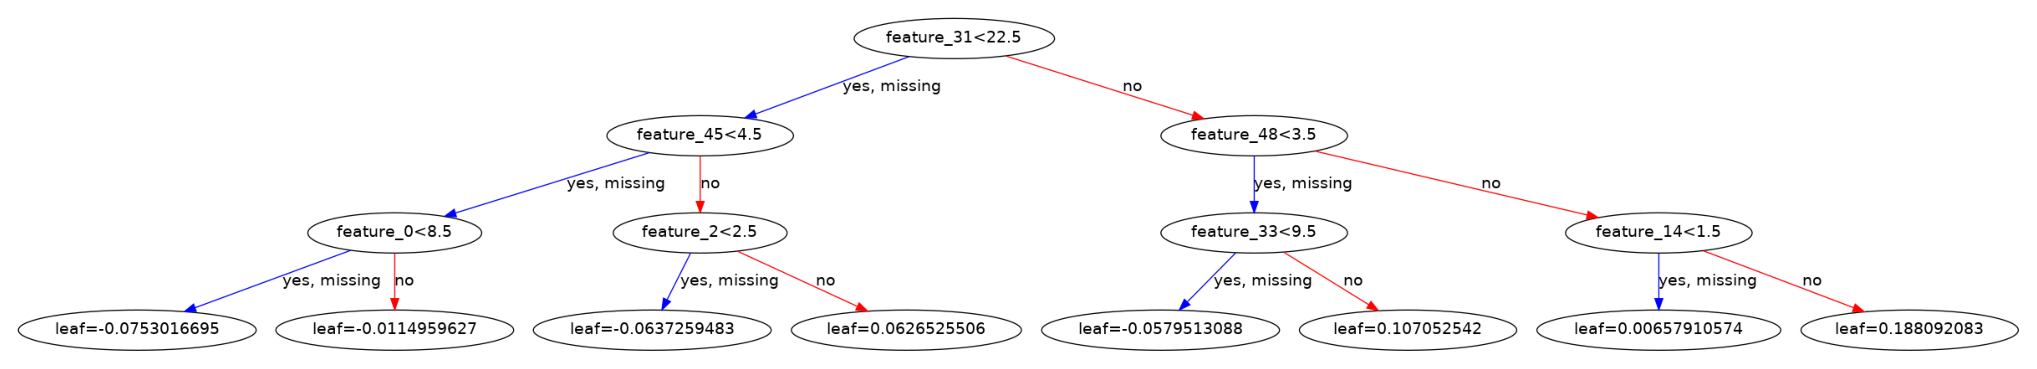

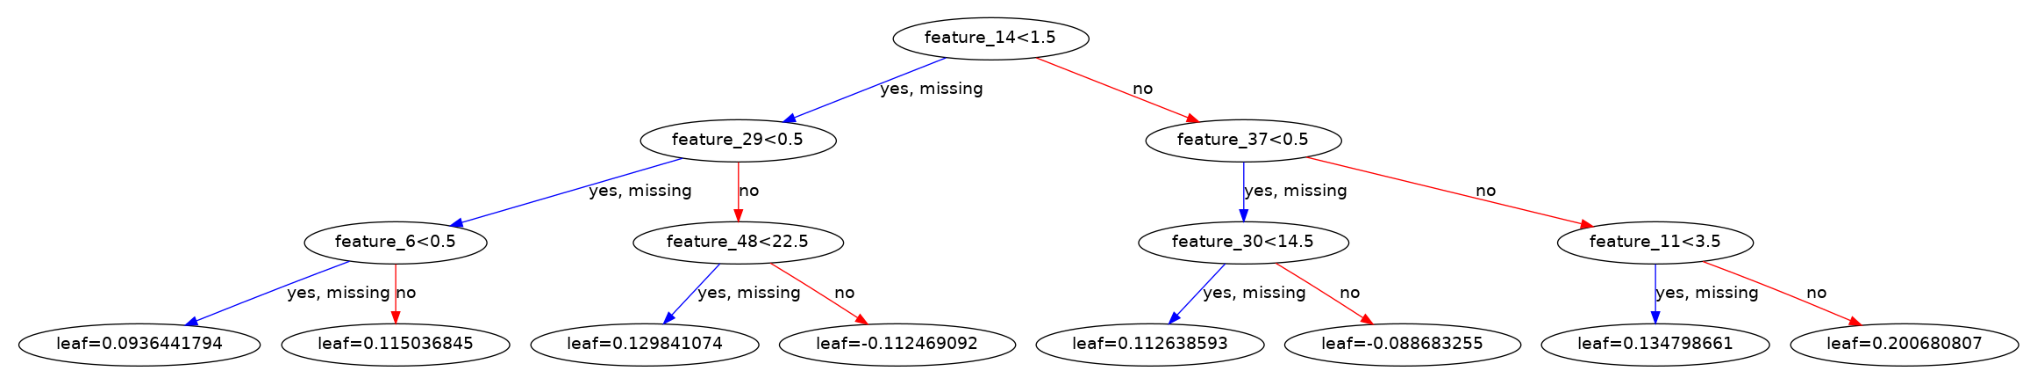

In [120]:
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 18,15
for i in range(10):
    xgb.plot_tree(bst, num_trees=i)
    fig = matplotlib.pyplot.gcf()
    # fig.set_size_inches(22,22)

[Click here for high res decision tree visual output](https://raw.githubusercontent.com/tombresee/XGBOOST/main/ENTER/image_of_tree.svg)

<div class="h3"><i>8. &ensp; Score Tracker</i></div> 


In [121]:

class_labels = ["Class_1","Class_2","Class_3","Class_4"]
sample_sub.drop(columns=class_labels, 
                inplace=True) # important

submission = (sample_sub.join(pd.DataFrame(data=preds_sub, 
                                           columns=class_labels)))

# print(submission)
submission.to_csv("my_submission.csv", index=False)


**Let's see how much I can improve:**
1. &ensp; Score:  **1.09758**  (rank at this point:  448 of 641, 70th percentile)
2. &ensp; Score:  **1.09593**  (rank at this point:  456 of 669, 68th percentile)
3. &ensp; Score:  **1.09331**  (rank at this point:  475 of 757, 62nd percentile)
4. &ensp; Score:  **1.09255**  (rank at this point:  454 of 760, 59th percentile)




Goal:  Break top 20%